In [1]:
from IPython.display import display, HTML

display(HTML("""
<div style="
    display: flex;
    flex-direction: column;
    justify-content: center;
    align-items: center;
    height: 90vh;
    text-align: center;
">

  <h1 style="margin-bottom: 40px;">
    Titanic: Machine Learning from Disaster
  </h1>

  <p style="font-size: 18px; margin-bottom: 80px;">
    Classification Models for Survival Prediction
  </p>

  <p style="font-size: 16px; margin-bottom: 40px;">
    Sara Alsiyat
  </p>

  <p style="font-size: 16px; margin-bottom: 10px;">
    Week 4 - MSDS 422
  </p>

  <p style="font-size: 16px; margin-bottom: 80px;">
    Practical Machine Learning
  </p>

  <p style="font-size: 16px;">
    February 2026
  </p>

</div>

<div style="page-break-after: always;"></div>
"""))

# Introduction
This project predicts passenger survival from the RMS Titanic disaster using supervised classification models. The Titanic sank on April 15, 1912, and more than 1,500 passengers and crew died. The event is often used as a real-world example of how human decisions, limited resources, and social factors can affect survival during emergency situations.

The training dataset used in this analysis was provided through Canvas by Dr. Irene Tsapara and is based on the Kaggle competition “Titanic: Machine Learning from Disaster.” It includes 891 passengers and features such as age, sex, passenger class, fare, family relationships, and embarkation port. The target variable is binary: whether a passenger survived (1) or did not survive (0). The unseen test dataset used for final prediction and scoring is obtained directly from Kaggle.

This work follows the CRISP-DM workflow used in class. The process begins with exploratory data analysis, followed by data preprocessing and feature engineering, and then model building and evaluation. Three classification models are trained and compared, as required in this module: Logistic Regression, Linear Discriminant Analysis (LDA), and K-Nearest Neighbors (KNN). Each model is tuned using cross-validation and evaluated on a held-out validation set using accuracy, precision, recall, F1-score, and ROC-AUC.

### Dataset Versioning and Workflow Overview
To keep the workflow reproducible and easy to audit, the dataset is managed in clear stages: the raw dataset, a cleaned dataset, a feature-engineered dataset, and the final modeling dataset. This helps prevent accidental leakage from later steps into earlier steps and makes the preprocessing decisions easier to review.

# Data Load and Libraries
In this section, I set up the working environment for the analysis. I configure global settings, define helper functions that are reused throughout the notebook, and load the training dataset. These steps ensure consistent results, reduce repeated code, and create a clear foundation for the exploratory analysis, preprocessing, and modeling that follow.

## Setup and Global Configuration
I define global configuration settings such as random seeds, plotting styles, and display options. These settings help ensure reproducibility and consistent outputs across all stages of the analysis.

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import numpy as np
import pandas as pd
from itertools import cycle

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import scipy.stats as stats
from scipy.stats import skew, kurtosis

from IPython.display import display, HTML

# Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model Selection and Validation
from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold, 
    cross_val_score,
    cross_val_predict,
    GridSearchCV
)

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

# Evaluation Metrics
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    log_loss
)

# Multicollinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Global Configuration
target_column = "Survived"
random_state = 42

# Northwestern colors
nu_purple = "#4E2A84"
nu_gray = "#E6E6E6"
nu_light_purple = "#B6ACD1"
nu_dark_gray = "#716C6B"


color_map = {
    "Logistic Regression": "#2e0f38",  # deep purple
    "LDA":                 "#1a2c54",  # navy
    "KNN":                 "#4d7b93",  # muted blue
    "QDA":                 "#b45dbb"   # lavender
}

missing_cmap = ListedColormap([nu_light_purple, nu_gray])

# Set default plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

## Helper Functions
I create helper functions used for data cleaning, feature engineering, visualization, and model evaluation. Defining these functions early improves code organization and avoids repetition later in the notebook.

In [3]:

def nu_style_table(df, caption=None):
    """Apply Northwestern-styled formatting to a pandas DataFrame."""
    return (
        df.style
        .set_table_styles(
            [
                {
                    "selector": "table",
                    "props": [
                        ("width", "100%"),
                        ("margin", "0 auto"),
                        ("border-collapse", "collapse"),
                    ],
                },
                {
                    "selector": "caption",
                    "props": [
                        ("caption-side", "top"),
                        ("font-weight", "bold"),
                        ("font-size", "14px"),
                        ("text-align", "center"),
                        ("white-space", "nowrap"),
                        ("padding-bottom", "6px"),
                    ],
                },
                {
                    "selector": "th",
                    "props": [
                        ("background-color", nu_purple),
                        ("color", "white"),
                        ("font-weight", "bold"),
                        ("text-align", "center"),
                        ("padding", "6px"),
                    ],
                },
                {
                    "selector": "td",
                    "props": [
                        ("background-color", nu_gray),
                        ("text-align", "center"),
                        ("padding", "6px"),
                    ],
                },
            ]
        )
        .set_caption(caption if caption else "")
    )


def display_side_by_side(table_left, table_right):
    """Display two styled tables side by side."""
    display(HTML(
        f"""
        <div style="display:flex; gap:40px; align-items:flex-start;">
            <div style="flex:1;">{table_left.to_html()}</div>
            <div style="flex:1;">{table_right.to_html()}</div>
        </div>
        """
    ))

def survival_rate_table(df, group_col, caption):
    tmp = (
        df.groupby(group_col)['Survived']
          .agg(['count', 'mean'])
          .reset_index()
          .rename(columns={'count': 'Count', 'mean': 'Survival Rate'})
    )
    tmp['Survival Rate'] = (tmp['Survival Rate'] * 100).round(1).astype(str) + '%'
    display(nu_style_table(tmp, caption=caption))
    
def sanitize_filename(name: str) -> str:
    """Clean a string to be safe for use as a filename."""
    name = name.lower().strip()
    name = re.sub(r"[^a-z0-9]+", "_", name)
    name = re.sub(r"_+", "_", name).strip("_")
    return name
    
def extract_title(name):
    """
    Extract title from passenger name.
    Titles provide insight into social status and can help impute missing ages.
    """
    if pd.isna(name):
        return "Unknown"
    
    match = re.search(r",\s*([^\.]+)\.", str(name))
    if match:
        title = match.group(1).strip()
        # Standardize titles
        title_mapping = {
            "Mlle": "Miss",
            "Ms": "Miss",
            "Mme": "Mrs",
            "Lady": "Rare",
            "Countess": "Rare",
            "Capt": "Rare",
            "Col": "Rare",
            "Don": "Rare",
            "Dr": "Rare",
            "Major": "Rare",
            "Rev": "Rare",
            "Sir": "Rare",
            "Jonkheer": "Rare",
            "Dona": "Rare"
        }
        return title_mapping.get(title, title)
    return "Unknown"


def extract_deck(cabin):
    """
    Extract deck letter from cabin number.
    Deck location may correlate with survival due to proximity to lifeboats.
    """
    if pd.isna(cabin):
        return "Unknown"
    return str(cabin)[0]


def extract_ticket_prefix(ticket):
    """
    Extract the prefix from ticket number.
    Shared prefixes may indicate group travel and social connections.
    """
    ticket = str(ticket).strip()
    parts = ticket.split()
    if len(parts) > 1:
        prefix = parts[0].replace('.', '').replace('/', '').upper()
        return prefix
    else:
        return "NONE"


def create_age_bins(age):
    """
    Bin ages into meaningful life stage categories.
    Based on historical context: children were prioritized for lifeboats.
    """
    if pd.isna(age):
        return "Unknown"
    elif age <= 12:
        return "Child"
    elif age <= 18:
        return "Teen"
    elif age <= 35:
        return "YoungAdult"
    elif age <= 60:
        return "Adult"
    else:
        return "Senior"


def create_fare_bins(fare):
    """
    Bin fares into economic categories.
    Fare is a proxy for socioeconomic status.
    """
    if pd.isna(fare):
        return "Unknown"
    elif fare <= 7.91:
        return "Low"
    elif fare <= 14.454:
        return "Medium_Low"
    elif fare <= 31.0:
        return "Medium_High"
    else:
        return "High"


def create_family_group(size):
    """
    Group family sizes into survival-optimal categories.
    Solo travelers and large families had lower survival rates.
    """
    if size == 1:
        return "Solo"
    elif size <= 4:
        return "Small"
    else:
        return "Large"



def evaluate_classifier(model, X_train, y_train, X_val, y_val, model_name):
    """
    Comprehensive evaluation of a classification model.
    Returns metrics for both training and validation sets.
    """
    # Predictions
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Probabilities
    if hasattr(model, "predict_proba"):
        y_train_prob = model.predict_proba(X_train)[:, 1]
        y_val_prob = model.predict_proba(X_val)[:, 1]
        train_auc = roc_auc_score(y_train, y_train_prob)
        val_auc = roc_auc_score(y_val, y_val_prob)
        train_logloss = log_loss(y_train, y_train_prob)
        val_logloss = log_loss(y_val, y_val_prob)
    else:
        train_auc = val_auc = np.nan
        train_logloss = val_logloss = np.nan
    
    results = {
        "Model": model_name,
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Val Accuracy": accuracy_score(y_val, y_val_pred),
        "Train Precision": precision_score(y_train, y_train_pred),
        "Val Precision": precision_score(y_val, y_val_pred),
        "Train Recall": recall_score(y_train, y_train_pred),
        "Val Recall": recall_score(y_val, y_val_pred),
        "Train F1": f1_score(y_train, y_train_pred),
        "Val F1": f1_score(y_val, y_val_pred),
        "Train AUC": train_auc,
        "Val AUC": val_auc,
        "Train LogLoss": train_logloss,
        "Val LogLoss": val_logloss
    }
    
    return results


def plot_confusion_matrix(y_true, y_pred, model_name, ax=None):
    """Plot confusion matrix with Northwestern colors."""
    cm = confusion_matrix(y_true, y_pred)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Purples',
        xticklabels=['Died', 'Survived'],
        yticklabels=['Died', 'Survived'],
        ax=ax,
        cbar=False
    )
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title(f'{model_name} - Confusion Matrix')
    
    return cm


def plot_roc_curve(y_true, y_prob, model_name, ax=None):
    """Plot ROC curve with AUC score."""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    ax.plot(fpr, tpr, color=nu_purple, linewidth=2, label=f'{model_name} (AUC = {auc:.3f})')
    ax.plot([0, 1], [0, 1], linestyle='--', color=nu_dark_gray, linewidth=1)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'{model_name} - ROC Curve')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    
    return auc


def plot_precision_recall_curve(y_true, y_prob, model_name, ax=None):
    """Plot Precision-Recall curve with Average Precision score."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))
    
    ax.plot(recall, precision, color=nu_purple, linewidth=2, label=f'{model_name} (AP = {ap:.3f})')
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title(f'{model_name} - Precision-Recall Curve')
    ax.legend(loc='lower left')
    ax.grid(True, alpha=0.3)
    
    return ap


def save_submission(predictions, passenger_ids, model_name, output_dir="output"):
    """Save Kaggle submission file."""
    os.makedirs(output_dir, exist_ok=True)
    
    fname = f"submission_{sanitize_filename(model_name)}.csv"
    path = os.path.join(output_dir, fname)
    
    submission = pd.DataFrame({
        "PassengerId": passenger_ids,
        "Survived": predictions.astype(int)
    })
    
    submission.to_csv(path, index=False)
    print(f"Saved: {path}")
    return path

def evaluate_prob_ensemble(y_true, prob_avg, threshold=0.5):
    preds = (prob_avg >= threshold).astype(int)
    return {
        "Accuracy": accuracy_score(y_true, preds),
        "Precision": precision_score(y_true, preds, zero_division=0),
        "Recall": recall_score(y_true, preds, zero_division=0),
        "F1-Score": f1_score(y_true, preds, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, prob_avg),
    }


## Load Training Data
I load the Titanic training dataset and perform basic checks to confirm that the data was imported correctly. Initial inspections, such as reviewing the dataset shape and column names, help verify data integrity before moving into exploratory data analysis.

In [4]:
# Load training data
train_df = pd.read_csv("train.csv")

# Store original for reference
train_raw = train_df.copy()

print(f"Training dataset loaded: {train_df.shape[0]} rows, {train_df.shape[1]} columns")

Training dataset loaded: 891 rows, 12 columns


# Data Presentation
In this section, I examine the structure of the dataset to understand what information is available and how the features are organized. I review the data types, inspect basic summary information, and identify the presence of missing values. This initial review helps establish a clear foundation for later preprocessing and feature engineering decisions.

## Dataset Overview

### Dataset dimensions

In [5]:
dataset_summary = pd.DataFrame({
    "Metric": ["Total Passengers", "Total Features", "Target Variable"],
    "Value": [train_df.shape[0], train_df.shape[1] - 1, "Survived"]
})

display(nu_style_table(dataset_summary, caption="Dataset Dimensions"))

,Metric,Value
0,Total Passengers,891
1,Total Features,11
2,Target Variable,Survived


The dataset contains 891 passenger records with 11 features used for analysis. The target variable, Survived, indicates whether a passenger lived or died during the disaster. This confirms that the dataset is well-sized for a binary classification task and suitable for exploratory analysis and supervised learning.

### Columns information

In [6]:
column_info = pd.DataFrame({
    "Column": train_df.columns,
    "Data Type": train_df.dtypes.values,
    "Non-Null Count": train_df.count().values,
    "Null Count": train_df.isnull().sum().values,
    "Null %": (train_df.isnull().sum() / len(train_df) * 100).round(2).values
})

display(nu_style_table(column_info, caption="Column Information Summary"))

,Column,Data Type,Non-Null Count,Null Count,Null %
0,PassengerId,int64,891,0,0.000000
1,Survived,int64,891,0,0.000000
2,Pclass,int64,891,0,0.000000
3,Name,object,891,0,0.000000
4,Sex,object,891,0,0.000000
5,Age,float64,724,167,18.740000
6,SibSp,int64,891,0,0.000000
7,Parch,int64,891,0,0.000000
8,Ticket,object,891,0,0.000000
9,Fare,float64,891,0,0.000000


Most variables in the dataset are complete, with no missing values. However, three features contain missing data. Cabin has a very high percentage of missing values (about 77%), which suggests it was not consistently recorded. Age is missing for about 19% of passengers, making it an important feature that requires careful imputation. Embarked has only two missing values and can be handled easily. These missing values will need targeted preprocessing before model building.

### Sample data

In [7]:
display(nu_style_table(train_df.head(10), caption="First 10 Rows of Training Data"))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,20.100000,1,0,A/5 21171,7.250000,nan,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,40.210000,1,0,PC 17599,71.283300,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,25.130000,0,0,STON/O2. 3101282,7.925000,nan,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,36.440000,1,0,113803,53.100000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,36.440000,0,0,373450,8.050000,nan,S
5,6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.458300,nan,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,60.320000,0,0,17463,51.862500,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,0.200000,3,1,349909,21.075000,nan,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,26.380000,0,2,347742,11.133300,nan,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,10.050000,1,0,237736,30.070800,nan,C


### Feature Descriptions
The dataset contains twelve variables that describe the demographic, socioeconomic, and travel-related characteristics of Titanic passengers.

PassengerId is a unique identifier for each passenger. Survived is the binary target variable, where 0 indicates the passenger did not survive and 1 indicates survival. Pclass represents ticket class (1 = first, 2 = second, 3 = third) and serves as a proxy for socioeconomic status. Name contains the passenger’s full name, including titles that provide information about gender and social standing. Sex records whether the passenger is male or female, which is an important variable given the historical evacuation priority of women and children (Frey, Savage, and Torgler 2010).

Age represents the passenger’s age in years, with fractional values for infants. SibSp and Parch indicate the number of siblings or spouses and parents or children traveling with the passenger, respectively. Ticket records the ticket number. Fare represents the price paid for the ticket and is closely related to passenger class. Cabin contains the cabin number when available, where the first letter reflects the deck level. Embarked identifies the port of embarkation: C (Cherbourg), Q (Queenstown), or S (Southampton).

# Exploratory Data Analysis (Initial)
Before cleaning and transforming the data, I conduct an initial exploratory analysis to understand how the variables are distributed, examine patterns related to passenger survival, and identify potential data quality issues. This step helps highlight missing values, class imbalance, and early relationships between features and the target variable, which guide the preprocessing and feature engineering decisions that follow.

## Target Variable Distribution
I examine the distribution of the target variable "Survived" to understand the balance between passengers who survived and those who did not. Reviewing the class distribution is important because class imbalance can affect model performance and evaluation. This analysis helps determine whether metrics such as precision, recall, and ROC-AUC are more informative than accuracy alone when comparing classification models.

,Outcome,Count,Percentage
0,Did Not Survive,549,61.6%
1,Survived,342,38.4%


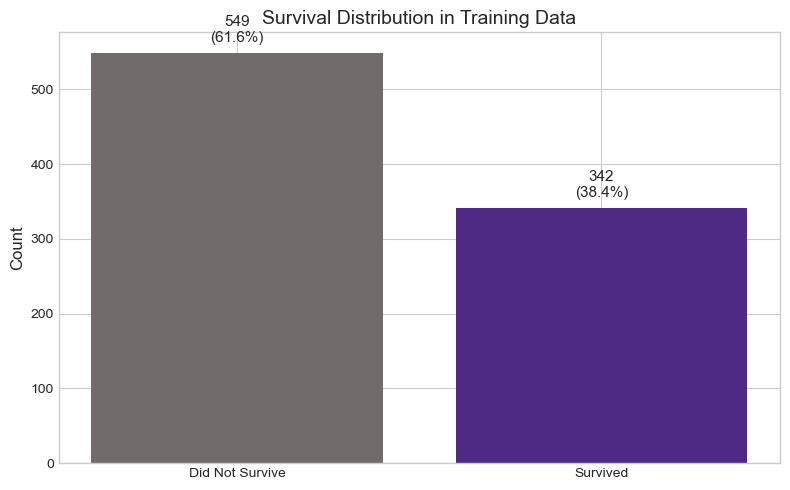


Class imbalance ratio: 1.61:1 (Not Survived : Survived)


In [8]:
# Target variable distribution
survival_counts = train_df['Survived'].value_counts()
survival_pct = train_df['Survived'].value_counts(normalize=True) * 100

target_summary = pd.DataFrame({
    "Outcome": ["Did Not Survive", "Survived"],
    "Count": [survival_counts[0], survival_counts[1]],
    "Percentage": [f"{survival_pct[0]:.1f}%", f"{survival_pct[1]:.1f}%"]
})

display(nu_style_table(target_summary, caption="Target Variable Distribution"))

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(['Did Not Survive', 'Survived'], survival_counts.values, color=[nu_dark_gray, nu_purple])
ax.set_ylabel('Count')
ax.set_title('Survival Distribution in Training Data')

# Add count labels on bars
for bar, count, pct in zip(bars, survival_counts.values, survival_pct.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
            f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

print(f"\nClass imbalance ratio: {survival_counts[0]/survival_counts[1]:.2f}:1 (Not Survived : Survived)")

The target variable is not evenly balanced. About 61.6% of passengers did not survive, while 38.4% survived. This makes sense based on what is known about the Titanic disaster, where fewer people survived overall. The imbalance is not extreme, but it means that accuracy by itself may not tell the full story. Because of this, precision and recall are more helpful when comparing the performance of the models

## Missing Values Analysis
In this section, I examine which features contain missing values and how much data is missing in each case. Understanding the pattern and extent of missing values is important because it helps determine whether the data can be safely imputed or if certain features require special handling. This analysis guides the preprocessing decisions used later in the modeling process.

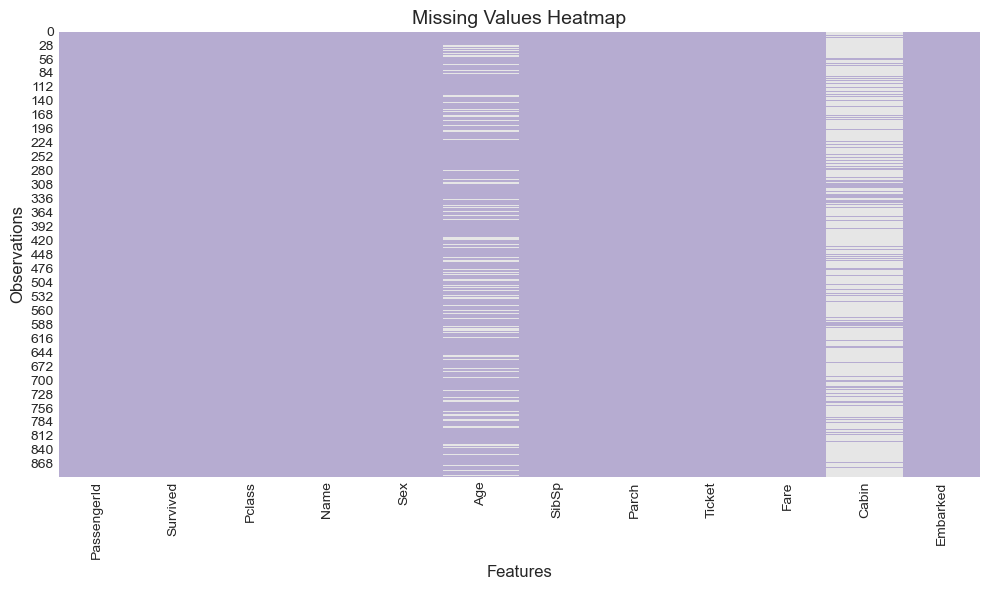

,Column,Missing Count,Missing %
0,Cabin,687,77.100000
1,Age,167,18.740000
2,Embarked,2,0.220000


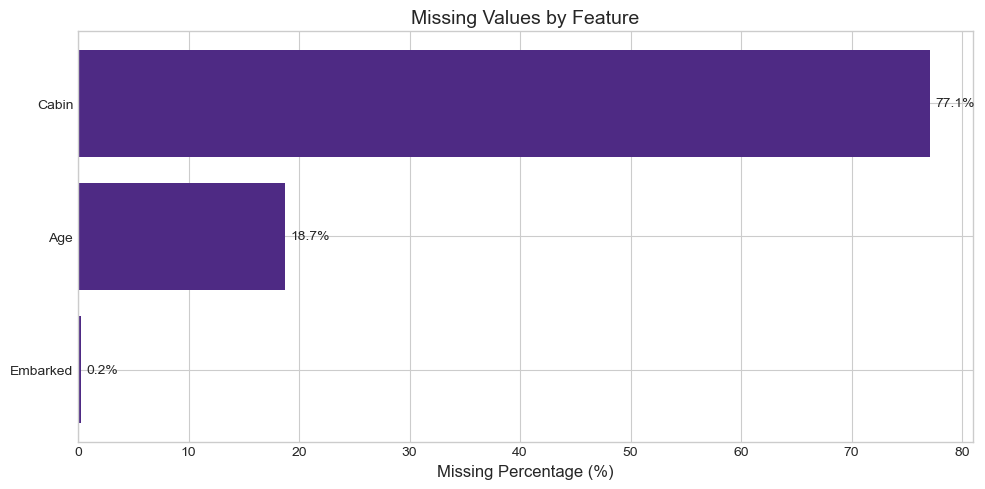

In [9]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    train_df.isnull(),
    cbar=False,
    cmap=missing_cmap
)

plt.title("Missing Values Heatmap")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.tight_layout()
plt.show()

# Missing values summary
missing_summary = pd.DataFrame({
    "Column": train_df.columns,
    "Missing Count": train_df.isnull().sum().values,
    "Missing %": (train_df.isnull().sum() / len(train_df) * 100).round(2).values
}).sort_values("Missing %", ascending=False)

missing_summary = missing_summary[missing_summary["Missing Count"] > 0]

display(nu_style_table(missing_summary.reset_index(drop=True), caption="Columns with Missing Values"))

# Visualize missing values
if len(missing_summary) > 0:
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.barh(missing_summary["Column"], missing_summary["Missing %"], color=nu_purple)
    ax.set_xlabel('Missing Percentage (%)')
    ax.set_title('Missing Values by Feature')
    ax.invert_yaxis()
    
    for bar, pct in zip(bars, missing_summary["Missing %"].values):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{pct:.1f}%', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()


Three variables in the dataset contain missing values, and the extent of missingness varies across features.

Cabin (77.1 percent missing). Cabin information is missing for most passengers. This suggests that cabin details were not consistently recorded, particularly for lower-class passengers. The high level of missingness indicates that cabin-related information is unevenly distributed across the dataset.

Age (19.9 percent missing). Age is missing for a noticeable portion of passengers. Since age is closely related to survival outcomes, especially given historical evacuation priorities, this missingness is important to note and will need careful consideration in later stages of the analysis.

Embarked (0.2 percent missing). Only two passengers have missing embarkation values. Compared to other variables, this feature is largely complete and shows minimal data loss.

## Numerical Features Analysis
In this subsection, I examine the numerical variables in the dataset to understand their basic characteristics and distributions. This initial review helps identify potential patterns and irregularities before exploring their relationship with passenger survival.

In [10]:
# Identify numerical columns
numerical_cols = ['Age', 'SibSp', 'Parch', 'Fare']

# Descriptive statistics
num_stats = train_df[numerical_cols].describe().T
num_stats['skewness'] = train_df[numerical_cols].skew()
num_stats['kurtosis'] = train_df[numerical_cols].kurtosis()

display(nu_style_table(num_stats.round(3), caption="Numerical Features - Descriptive Statistics"))

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
Age,724.000000,29.699000,17.894000,0.200000,17.590000,27.640000,40.210000,93.000000,0.529000,0.105000
SibSp,891.000000,0.523000,1.103000,0.000000,0.000000,0.000000,1.000000,8.000000,3.695000,17.880000
Parch,891.000000,0.382000,0.806000,0.000000,0.000000,0.000000,0.000000,6.000000,2.749000,9.778000
Fare,891.000000,32.204000,49.693000,0.000000,7.910000,14.454000,31.000000,512.329000,4.787000,33.398000


The numerical features show different distribution patterns. Age is fairly centered around the late twenties with a slight right skew. In contrast, SibSp and Parch are highly skewed, with most passengers having values of zero, meaning many traveled without close family members. Fare is the most skewed variable and also has very high kurtosis, caused by a small number of passengers who paid extremely high fares.

Skewness describes whether the data is pulled more to the left or right side of the distribution, while kurtosis shows whether a variable has extreme values or outliers. Higher kurtosis indicates the presence of more extreme values. Overall, Fare, SibSp, and Parch show strong skewness and kurtosis, suggesting that these variables are not normally distributed.

### Distribution plots for numerical features
In this subsection, I visualize the distributions of the numerical variables to better understand their shapes, spread, and potential outliers. These plots complement the descriptive statistics and help reveal patterns that are not always clear from summary tables alone.

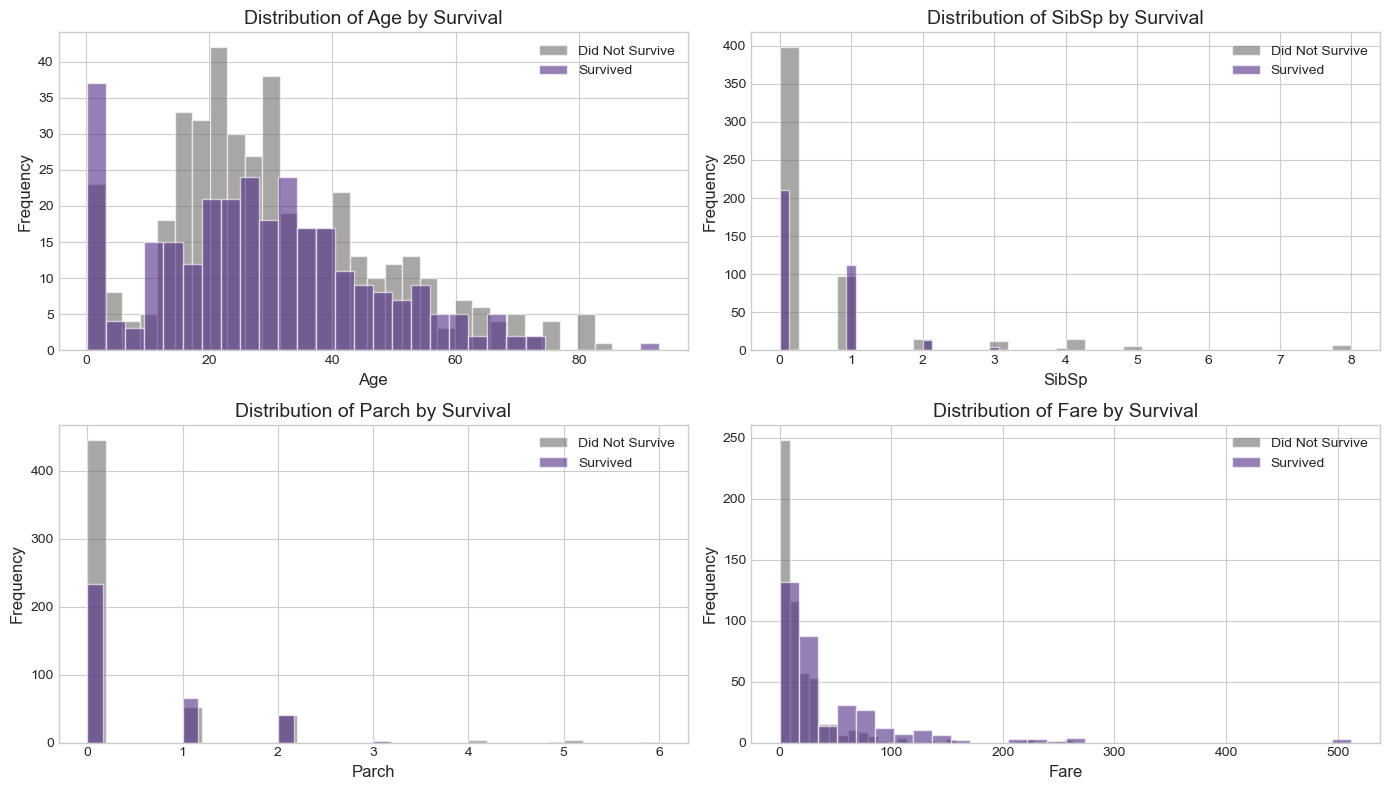

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

for idx, col in enumerate(numerical_cols):
    ax = axes[idx // 2, idx % 2]
    
    # Plot distribution by survival
    for survived, color, label in [(0, nu_dark_gray, 'Did Not Survive'), (1, nu_purple, 'Survived')]:
        data = train_df[train_df['Survived'] == survived][col].dropna()
        ax.hist(data, bins=30, alpha=0.6, color=color, label=label, edgecolor='white')
    
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {col} by Survival')
    ax.legend()

plt.tight_layout()
plt.show()

The distribution plots show some differences between survivors and non-survivors. Age overlaps a lot between the two groups, although survivors tend to be slightly younger overall. Most passengers traveled alone, but survival appears more common for those traveling with one or two family members. Fare shows the strongest difference, with survivors more often found at higher fare values, while non-survivors are concentrated in the lowest fare ranges. Overall, fare and family-related variables appear more strongly related to survival than age.

### Age Analysis
In this subsection, I focus on passenger age. Age is examined to understand its distribution and how it relates to survival outcomes, especially given the historical evacuation priorities during the Titanic disaster.

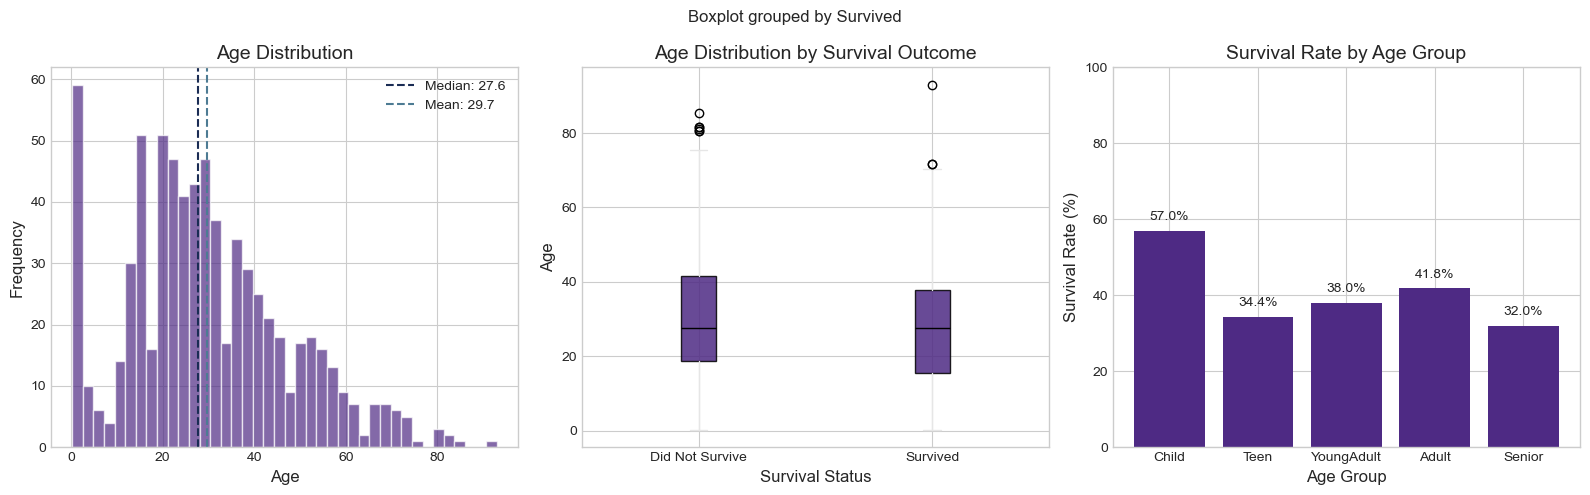

,mean,median,std,min,max
Did Not Survive,30.680000,27.640000,17.750000,0.200000,85.460000
Survived,28.260000,27.640000,18.040000,0.200000,93.000000


In [12]:
# Detailed Age analysis
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Age distribution with KDE
ax1 = axes[0]
train_df['Age'].dropna().hist(bins=40, ax=ax1, color=nu_purple, alpha=0.7, edgecolor='white')
ax1.set_xlabel('Age')
ax1.set_ylabel('Frequency')
ax1.set_title('Age Distribution')
ax1.axvline(train_df['Age'].median(), color='#1a2c54', linestyle='--', label=f'Median: {train_df["Age"].median():.1f}')
ax1.axvline(train_df['Age'].mean(), color='#4d7b93', linestyle='--', label=f'Mean: {train_df["Age"].mean():.1f}')
ax1.legend()

# Age by survival (box plot)

ax2 = axes[1]

train_df.boxplot(
    column="Age",
    by="Survived",
    ax=ax2,
    patch_artist=True,
    boxprops=dict(facecolor=nu_purple, alpha=0.85),
    medianprops=dict(color="black"),
    whiskerprops=dict(color=nu_gray),
    capprops=dict(color=nu_gray)
)

ax2.set_xlabel("Survival Status")
ax2.set_ylabel("Age")
ax2.set_title("Age Distribution by Survival Outcome")
ax2.set_xticks([1, 2])
ax2.set_xticklabels(["Did Not Survive", "Survived"])



# Survival rate by age group
ax3 = axes[2]
age_bins = [0, 12, 18, 35, 60, 100]
age_labels = ['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior']
train_df['AgeBinTemp'] = pd.cut(train_df['Age'], bins=age_bins, labels=age_labels)
survival_by_age = train_df.groupby('AgeBinTemp')['Survived'].mean() * 100
bars = ax3.bar(survival_by_age.index, survival_by_age.values, color=nu_purple)
ax3.set_xlabel('Age Group')
ax3.set_ylabel('Survival Rate (%)')
ax3.set_title('Survival Rate by Age Group')
ax3.set_ylim(0, 100)

for bar, rate in zip(bars, survival_by_age.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)



train_df.drop('AgeBinTemp', axis=1, inplace=True)

plt.tight_layout()
plt.show()

# Age statistics by survival
age_by_survival = train_df.groupby('Survived')['Age'].agg(['mean', 'median', 'std', 'min', 'max'])
age_by_survival.index = ['Did Not Survive', 'Survived']
display(nu_style_table(age_by_survival.round(2), caption="Age Statistics by Survival Status"))

Children have the highest survival rate, at about 57 percent, while teens and seniors have lower and similar survival rates. Young adults and adults fall in between these groups. Survivors are slightly younger on average than non-survivors, but the median age is the same for both. Overall, there is a large overlap in age between survivors and non-survivors, suggesting that age mainly affects survival for children rather than for other age groups.

## Categorical Features Analysis
In this section, I examine the categorical variables in the dataset to understand how different groups are distributed and how they relate to passenger survival. This analysis helps identify patterns across categories such as gender, passenger class, and embarkation port.

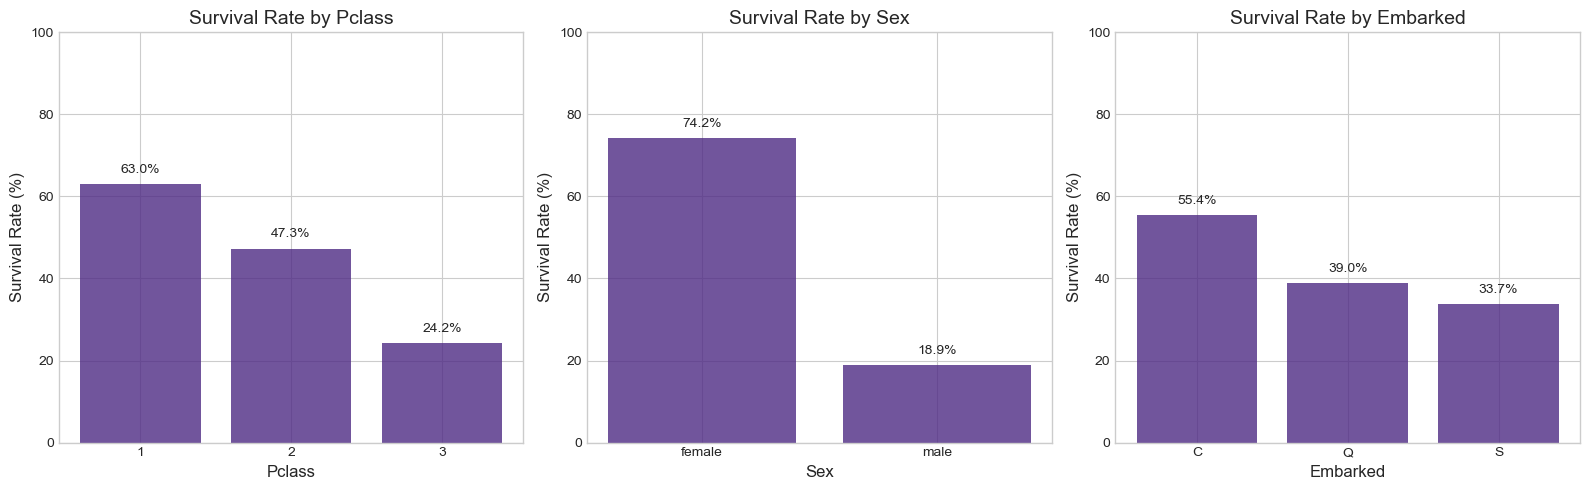

In [13]:
# Categorical features
categorical_cols = ['Pclass', 'Sex', 'Embarked']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for idx, col in enumerate(categorical_cols):
    ax = axes[idx]
    
    # Calculate survival rate by category
    survival_rate = train_df.groupby(col)['Survived'].mean() * 100
    counts = train_df[col].value_counts().sort_index()
    
    # Plot
    bars = ax.bar(range(len(survival_rate)), survival_rate.values, color=nu_purple, alpha=0.8)
    ax.set_xticks(range(len(survival_rate)))
    ax.set_xticklabels(survival_rate.index)
    ax.set_xlabel(col)
    ax.set_ylabel('Survival Rate (%)')
    ax.set_title(f'Survival Rate by {col}')
    ax.set_ylim(0, 100)
    
    # Add percentage labels
    for bar, rate in zip(bars, survival_rate.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

The survival rates differ clearly across passenger class, gender, and embarkation port. First-class passengers had much higher survival rates than those in third class. Females were far more likely to survive than males, which strongly reflects evacuation priorities. Survival also varies by embarkation port, with Cherbourg showing the highest survival rate. Overall, gender and passenger class stand out as the strongest categorical factors related to survival.

### Sex analysis
This subsection examines survival differences between male and female passengers to understand how gender relates to survival outcomes.

In [14]:
sex_survival = train_df.groupby('Sex').agg({
    'Survived': ['count', 'sum', 'mean']
}).round(3)
sex_survival.columns = ['Total', 'Survived', 'Survival Rate']
sex_survival['Survival Rate'] = (sex_survival['Survival Rate'] * 100).round(1).astype(str) + '%'

display(nu_style_table(sex_survival, caption="Survival by Gender"))

,Total,Survived,Survival Rate
Sex,,,
female,314,233,74.2%
male,577,109,18.9%


Survival differs greatly by gender. About 74.2 percent of female passengers survived, compared to only 18.9 percent of male passengers. This large difference is consistent with the “women and children first” evacuation priority during the disaster.

### Pclass analysis

In [15]:
pclass_survival = train_df.groupby('Pclass').agg({
    'Survived': ['count', 'sum', 'mean'],
    'Fare': 'mean'
}).round(3)
pclass_survival.columns = ['Total', 'Survived', 'Survival Rate', 'Avg Fare']
pclass_survival['Survival Rate'] = (pclass_survival['Survival Rate'] * 100).round(1).astype(str) + '%'
pclass_survival['Avg Fare'] = '$' + pclass_survival['Avg Fare'].round(2).astype(str)
pclass_survival.index = ['First Class', 'Second Class', 'Third Class']

display(nu_style_table(pclass_survival, caption="Survival by Passenger Class"))

,Total,Survived,Survival Rate,Avg Fare
First Class,216,136,63.0%,$84.16
Second Class,184,87,47.3%,$20.66
Third Class,491,119,24.2%,$13.68


Survival rates vary clearly by passenger class. First-class passengers had the highest survival rate at 63.0 percent, followed by second class at 47.3 percent. Third-class passengers had the lowest survival rate at 24.2 percent. Average fares also decrease sharply from first class to third class, suggesting that passenger class, as a proxy for socioeconomic status, was strongly related to survival.

## Correlation Analysis
In this section, I examine the correlation between selected features and the target variable, Survived. Correlation analysis helps identify which variables have stronger linear relationships with survival and provides guidance for feature selection before modeling.

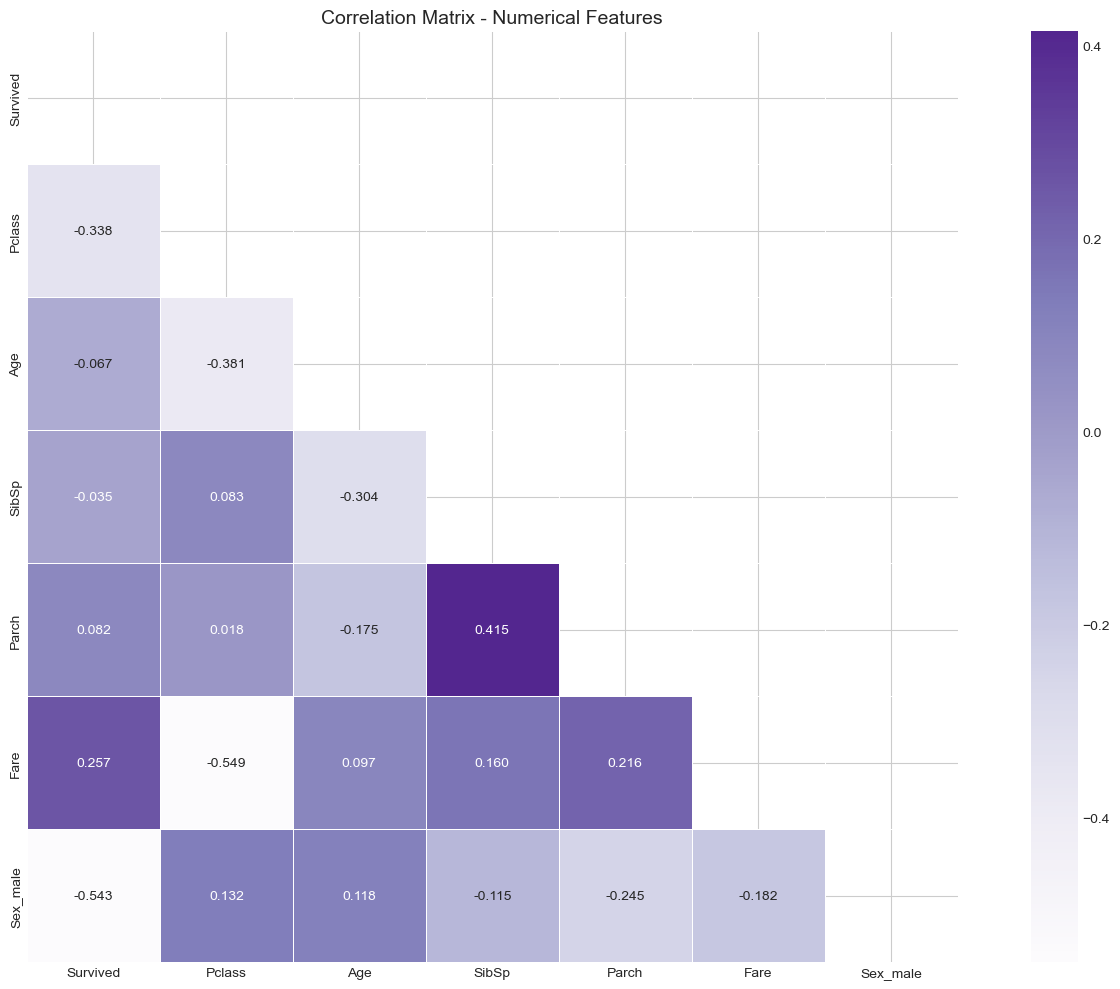

,Feature,Correlation with Survival
0,Sex_male,-0.543000
1,Pclass,-0.338000
2,Fare,0.257000
3,Parch,0.082000
4,Age,-0.067000
5,SibSp,-0.035000


In [16]:
corr_df = train_df[['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']].copy()
corr_df['Sex_male'] = (train_df['Sex'] == 'male').astype(int)

# Correlation matrix
corr_matrix = corr_df.corr()

# Heatmap
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, 
    mask=mask,
    annot=True, 
    fmt='.3f', 
    cmap='Purples',
    center=0,
    ax=ax,
    square=True,
    linewidths=0.5
)
ax.set_title('Correlation Matrix - Numerical Features')
plt.tight_layout()
plt.show()

# Correlation with target
target_corr = corr_matrix['Survived'].drop('Survived').sort_values(key=abs, ascending=False)
corr_summary = pd.DataFrame({
    'Feature': target_corr.index,
    'Correlation with Survival': target_corr.values.round(3)
})

display(nu_style_table(corr_summary, caption="Feature Correlations with Survival (sorted by absolute value)"))

The correlation analysis shows that gender is the strongest factor related to survival. Being male has a strong negative correlation with survival, while passenger class also shows a clear negative relationship. Fare has a moderate positive correlation, meaning higher fares are linked to better survival chances. Age, SibSp, and Parch have very weak correlations, suggesting they have limited linear impact on survival on their own.

# Overview of Findings and Next Steps
This section summarizes the main insights from the initial exploratory data analysis and explains what needs to be done before building the classification models.

## Key Findings from Initial EDA
The target variable shows a moderate class imbalance. About 61.6 percent of passengers did not survive, while 38.4 percent survived. This imbalance is not severe, but it means that accuracy alone is not enough to judge model performance. Metrics such as precision and recall will be more useful when evaluating the models.

Several features show clear relationships with survival. Gender is the strongest factor, as female passengers had a much higher survival rate (around 74 percent) compared to male passengers (about 19 percent). Passenger class is also strongly related to survival. First-class passengers had a survival rate of roughly 63 percent, while third-class passengers had a much lower survival rate of about 24 percent. Fare shows a positive relationship with survival as well, suggesting that passengers who paid higher fares were more likely to survive.

Missing values are concentrated in only a few variables. Cabin has a very high number of missing values, around 77 percent, which suggests that whether cabin information exists may be meaningful. Age has about 20 percent missing values, while Embarked has only a small number of missing records. These patterns indicate that missing values should be handled differently for each feature rather than using a single approach.

Age analysis shows that children had higher survival rates than other age groups, which matches historical evacuation priorities. However, survival differences among adults, teens, and seniors are relatively small. This suggests that age alone does not strongly separate survivors from non-survivors.

## Next Steps for Data Preparation and Modeling
Based on the initial EDA, several preprocessing steps are needed before model building. Missing values will be handled using feature-specific strategies, such as creating a cabin availability indicator, imputing age based on passenger titles, and filling missing embarkation values with the most common category.

Feature engineering will be used to improve model performance by creating variables such as family size, title-based features, cabin indicators, and age groups. Categorical variables will be encoded into numerical form, and numerical features will be scaled where needed. Finally, the dataset will be split into training and validation sets to support model training and tuning, and the final models will be evaluated using the Kaggle test dataset.

# Data Preprocessing and Feature Engineering
In this section, the data is prepared for modeling by cleaning the dataset, handling missing values, and creating new features. These steps are informed by patterns observed during the exploratory data analysis and by domain knowledge related to the Titanic disaster. The goal of this stage is to improve data quality and to represent important survival-related information in a way that can be effectively used by classification models.

In [17]:
# Training data copy
df = train_df.copy()

## Missing Value Treatment
In this section, missing values are handled using feature-specific strategies based on patterns observed during exploratory data analysis. Rather than applying a single method to all variables, each feature is treated in a way that best reflects its meaning and role in the dataset.

### Age
Age has a noticeable amount of missing values, and it is also an important feature for survival prediction. Instead of using one overall median age, missing ages are filled using the median age within each passenger title group (for example, Mr, Miss, Mrs). This keeps the imputed values more realistic because titles are strongly connected to age patterns in this dataset.

#### Age Imputation

In [18]:
# Calculate median age by title
df['Title'] = df['Name'].apply(extract_title)

age_by_title = (
    df.groupby('Title')['Age']
      .median()
      .reset_index()
      .rename(columns={'Age': 'Median Age'})
)

display(
    nu_style_table(
        age_by_title.round(2),
        caption="Median Age by Passenger Title (Before Imputation)"
    )
)

# Fill missing ages using title-specific medians
df['Age'] = df.apply(
    lambda row: age_by_title.loc[
        age_by_title['Title'] == row['Title'], 'Median Age'
    ].values[0]
    if pd.isna(row['Age']) else row['Age'],
    axis=1
)

# Remaining missing age values
age_missing_summary = pd.DataFrame({
    'Metric': ['Missing Age Values After Imputation'],
    'Value': [df['Age'].isnull().sum()]
})

display(
    nu_style_table(
        age_missing_summary,
        caption="Age Missing Values After Imputation"
    )
)

,Title,Median Age
0,Master,0.200000
1,Miss,18.840000
2,Mr,30.160000
3,Mrs,36.440000
4,Rare,54.040000
5,the Countess,33.930000


,Metric,Value
0,Missing Age Values After Imputation,0


Median age varies clearly by passenger title. Children (Master) have the lowest median age, while rare titles have much higher median ages, reflecting older passengers. After imputing missing ages using title-specific medians, no missing age values remain, ensuring that age can be safely used in modeling.

#### Age Binning
After age is fully imputed, ages are grouped into bins to make patterns easier to interpret and to support feature engineering used later in the models.

In [19]:
df['AgeBin'] = pd.cut(
    df['Age'],
    bins=[-np.inf, 12, 18, 35, 60, np.inf],
    labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior']
).astype('object')

agebin_dist = (
    df['AgeBin']
    .value_counts()
    .reindex(['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])
    .reset_index()
)

agebin_dist.columns = ['AgeBin', 'Count']

display(
    nu_style_table(
        agebin_dist,
        caption="Age Bin Distribution (After Imputation)"
    )
)

,AgeBin,Count
0,Child,97
1,Teen,96
2,YoungAdult,429
3,Adult,219
4,Senior,50


Most passengers fall into the Young Adult and Adult age groups. Young adults make up the largest portion of the dataset, followed by adults. Children, teens, and seniors appear in much smaller numbers. This shows that the Titanic mostly carried working-age passengers. Grouping age into bins helps make age patterns easier to see and allows the models to learn differences between life stages instead of relying only on exact age values.

### Embarked
Embarked has only a very small number of missing values, so the simplest and most reasonable approach is to fill them using the most common embarkation port (mode).

In [20]:
embarked_mode = df['Embarked'].mode()[0]

# Fill missing values
df['Embarked'] = df['Embarked'].fillna(embarked_mode)

# Create summary table
embarked_impute_summary = pd.DataFrame({
    'Metric': ['Imputed Value (Mode)', 'Missing After Imputation'],
    'Value': [embarked_mode, df['Embarked'].isnull().sum()]
})

display(
    nu_style_table(
        embarked_impute_summary,
        caption="Embarked Imputation Summary"
    )
)

,Metric,Value
0,Imputed Value (Mode),S
1,Missing After Imputation,0


Only two passengers had missing embarkation values. These were filled using the most common port, Southampton (S). After this step, there are no remaining missing values in the Embarked feature.

### Missing Values Heatmap

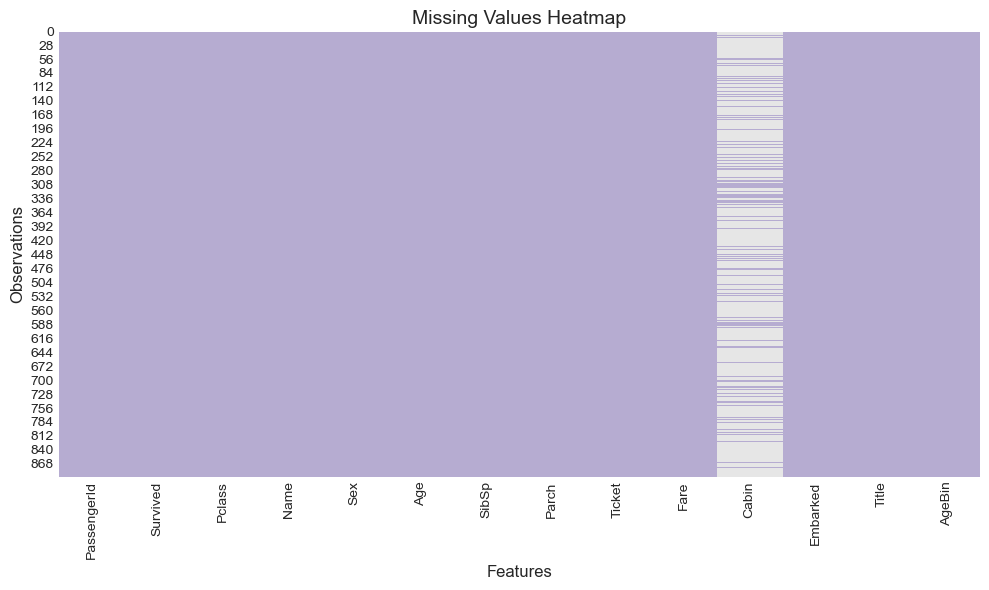

In [21]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    df.isnull(),
    cbar=False,
    cmap=missing_cmap
)

plt.title("Missing Values Heatmap")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.tight_layout()
plt.show()

## Feature Engineering
In this subsection, new features are created to better capture patterns related to survival that are not directly represented in the original variables. These engineered features are based on insights from the exploratory analysis and aim to improve model performance and interpretability by summarizing family structure, social status, and cabin availability.

### Title Distribution

In [22]:
df['NameLength'] = df['Name'].astype(str).apply(len)

title_summary = (
    df['Title']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'Title', 'Title': 'Count'})
)

display(
    nu_style_table(
        title_summary,
        caption="Title Distribution"
    )
)

,Count,count
0,Mr,517
1,Miss,185
2,Mrs,126
3,Master,40
4,Rare,22
5,the Countess,1


Most passengers fall under the titles Mr, Miss, and Mrs, with Mr being the most common. A smaller number of passengers are labeled as Master, which usually represents young boys. Very few passengers have rare titles, such as nobility-related titles, indicating that these groups are uncommon in the dataset.

### Family Features
This subsection focuses on features that describe whether passengers traveled alone or with family members. Family relationships may affect survival because passengers traveling together could help each other during evacuation or make coordinated decisions.

#### Family Identification
Passenger surnames are extracted from names to identify family groups. Because surnames alone can be ambiguous, passenger class is included to form a more precise family identifier.

In [23]:
df['Surname'] = df['Name'].apply(lambda x: str(x).split(',')[0].strip())
df['FamilyId'] = df['Surname'] + '_' + df['Pclass'].astype(str)

#### Family Size, Solo Travel, and Child Indicator
Family size is created by combining the number of siblings/spouses and parents/children a passenger traveled with, plus the passenger themself. I also add an IsAlone flag to mark passengers who traveled solo, since being alone may affect access to help during evacuation. Finally, I add an IsChild flag for passengers age 12 or younger to capture survival patterns related to children.

To support later family-based features, I also extract each passenger’s surname from the name field and combine it with passenger class to build a FamilyId. This helps group likely relatives while keeping the grouping more specific than surname alone.

In [24]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['IsChild'] = (df['Age'] <= 12).astype(int)

#### Family Group Categories
To simplify interpretation, family sizes are grouped into broader categories. This allows the models to capture non-linear effects related to very small or very large family groups.

In [25]:
df['FamilyGroup'] = df['FamilySize'].apply(create_family_group)

#### Family Structure Summary
The table below summarizes key statistics related to family structure in the dataset.

In [26]:
family_summary = pd.DataFrame({
    'Metric': [
        'Minimum Family Size',
        'Maximum Family Size',
        'Passengers Traveling Alone',
        'Percentage Traveling Alone'
    ],
    'Value': [
        int(df['FamilySize'].min()),
        int(df['FamilySize'].max()),
        int(df['IsAlone'].sum()),
        f"{df['IsAlone'].mean() * 100:.1f}%"
    ]
})

display(
    nu_style_table(
        family_summary,
        caption="Family Structure Summary"
    )
)

,Metric,Value
0,Minimum Family Size,1
1,Maximum Family Size,11
2,Passengers Traveling Alone,537
3,Percentage Traveling Alone,60.3%


Most passengers traveled alone, with about 60 percent having no accompanying family members. Family size ranges from one to eleven, but larger family groups are relatively rare. This suggests that family structure may play a role in survival and is worth including as an engineered feature.

#### Family Group Distribution
This table shows how passengers are distributed across different family group categories.

In [27]:
family_group_dist = (
    df['FamilyGroup']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'Family Group', 'FamilyGroup': 'Count'})
)

display(
    nu_style_table(
        family_group_dist,
        caption="Family Group Distribution"
    )
)

,Count,count
0,Solo,537
1,Small,292
2,Large,62


Most passengers traveled alone, with 537 individuals classified as solo travelers. A smaller portion traveled in small family groups (292 passengers), while large family groups were relatively rare, with only 62 passengers. This shows that the majority of passengers did not have close family support onboard, which may have influenced survival outcomes later in the analysis.

#### Family-Level Survival Signal (Leave-One-Out)
In addition to basic family structure features, a family-level survival signal is created to capture patterns shared among related passengers. For each passenger, the survival rate of other family members is calculated using a leave-one-out approach, meaning the passenger’s own survival outcome is excluded from the calculation. When a passenger has no other family members onboard, a neutral value is assigned. This approach helps capture family-level survival tendencies while reducing bias and preventing information leakage, since the passenger’s own outcome is not used in the feature calculation.

In [28]:
df['FamSurvRate'] = 0.5  # default neutral value

for idx in range(len(df)):
    fam_id = df.iloc[idx]['FamilyId']
    fam_mask = (df['FamilyId'] == fam_id) & (df.index != idx)
    fam_others = df.loc[fam_mask, 'Survived']
    if len(fam_others) > 0:
        df.loc[idx, 'FamSurvRate'] = fam_others.mean()

display(
    nu_style_table(
        df['FamSurvRate'].describe().round(3).reset_index(),
        caption="Family Survival Rate Feature Summary (Leave-One-Out)"
    )
)

,index,FamSurvRate
0,count,891.000000
1,mean,0.469000
2,std,0.280000
3,min,0.000000
4,25%,0.500000
5,50%,0.500000
6,75%,0.500000
7,max,1.000000


The family survival rate feature shows noticeable differences in survival outcomes across families. The average value is about 0.47, and many passengers have a value of 0.50, which usually indicates that they traveled alone or had family members with mixed survival outcomes. At the extremes, some families had no survivors, while others had all members survive.

This feature is useful because family members often stayed together during the evacuation and were affected by similar conditions. By using the survival outcomes of other family members only, this variable captures shared family patterns without relying on the passenger’s own survival result.

### Cabin Features
Cabin-related information is highly incomplete in the dataset, but the presence of cabin data itself can still be informative. Instead of treating missing cabin values as a problem, cabin-related features are engineered to capture differences in passenger status and ship location that may influence survival.

Although detailed cabin data is missing for most passengers, the engineered cabin features help preserve useful information without forcing unrealistic imputations. Indicators such as cabin availability, deck level, and cabin count provide indirect signals about passenger class and where passengers were located on the ship, which can improve model performance while staying consistent with the available data.

#### Cabin Availability
This subsection creates a simple binary indicator showing whether cabin information is recorded for a passenger. Even though most cabin values are missing, having a recorded cabin often indicates a higher passenger class and better access to lifeboats.

In [29]:
df['HasCabin'] = df['Cabin'].notna().astype(int)

cabin_summary = pd.DataFrame({
    'Metric': [
        'Passengers with Cabin Info',
        'Passengers without Cabin Info',
        'Percent with Cabin Info'
    ],
    'Value': [
        int(df['HasCabin'].sum()),
        int((df['HasCabin'] == 0).sum()),
        f"{df['HasCabin'].mean() * 100:.1f}%"
    ]
})

display(
    nu_style_table(
        cabin_summary,
        caption="Cabin Information Summary"
    )
)

,Metric,Value
0,Passengers with Cabin Info,204
1,Passengers without Cabin Info,687
2,Percent with Cabin Info,22.9%


Only a small portion of passengers (22.9%) have cabin information available, while the majority do not. This suggests that missing cabin data is very common and likely reflects how records were kept rather than a data error. Because of this, the presence of cabin information itself may still be useful as a signal, even without knowing the exact cabin details.

#### Deck Extraction
When cabin information is available, the first letter of the cabin number is used to identify the deck level. Passengers without cabin information are assigned to an “Unknown” deck. Decks can act as a rough proxy for ship location and passenger class.

In [30]:
df['Deck'] = df['Cabin'].apply(lambda x: str(x)[0] if pd.notna(x) else 'U')

deck_summary = (
    df['Deck']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'Deck', 'Deck': 'Count'})
)

display(
    nu_style_table(
        deck_summary,
        caption="Deck Distribution (U = Unknown)"
    )
)

,Count,count
0,U,687
1,C,59
2,B,47
3,D,33
4,E,32
5,A,15
6,F,13
7,G,4
8,T,1


Most passengers are assigned to the unknown deck (U), which is expected given the high amount of missing cabin data. Among the known decks, higher decks such as A, B, and C appear more frequently than lower decks, reflecting differences in passenger accommodation and ship layout.

#### Number of Cabins per Passenger
Some passengers are associated with more than one cabin. The total number of cabins listed for a passenger is used as an additional feature, which may reflect differences in passenger class or shared accommodations among family members or groups.

In [31]:
df['CabinCount'] = df['Cabin'].apply(
    lambda x: len(str(x).split()) if pd.notna(x) else 0
)

cabin_count_summary = pd.DataFrame({
    'Metric': [
        'Passengers with 0 Cabins',
        'Passengers with 1 Cabin',
        'Passengers with 2 or More Cabins'
    ],
    'Value': [
        int((df['CabinCount'] == 0).sum()),
        int((df['CabinCount'] == 1).sum()),
        int((df['CabinCount'] >= 2).sum())
    ]
})

display(
    nu_style_table(
        cabin_count_summary,
        caption="Cabin Count Summary"
    )
)

,Metric,Value
0,Passengers with 0 Cabins,687
1,Passengers with 1 Cabin,180
2,Passengers with 2 or More Cabins,24


Most passengers do not have cabin information recorded, which matches the high level of missing cabin data in the dataset. Among passengers with cabin records, the majority are associated with a single cabin, while only a small number have two or more cabins, suggesting special accommodations or group arrangements.

### Ticket-Based Features
Passengers on the Titanic often traveled in groups and shared the same ticket number. These shared tickets usually indicate family members or small travel groups who stayed together during the journey. Because survival decisions were often made at the group level, ticket-related information can help capture patterns that are not visible from individual features alone.

To represent this group structure, several ticket-based features are engineered. These features describe how many passengers share the same ticket and whether the ticket follows a common or rare format. All ticket-based features are created using both the training and test datasets together to ensure consistent group sizes, while survival labels are only used when calculating training features.

#### Ticket Group Size
The number of passengers associated with the same ticket is used to create a group size feature. This value reflects how many people were likely traveling together. Larger ticket groups may indicate families or organized groups, which could influence survival outcomes due to shared decisions and proximity during evacuation.

This feature helps distinguish between passengers traveling alone and those traveling as part of a group, without relying on explicit family relationships.

In [32]:
# Count how many times each ticket appears
ticket_counts = df['Ticket'].value_counts()

# Map ticket group size to training data
df['TicketGroupSize'] = df['Ticket'].map(ticket_counts)


# Summary table
ticket_group_summary = pd.DataFrame({
    'Metric': ['Min Ticket Group Size', 'Max Ticket Group Size'],
    'Value': [
        df['TicketGroupSize'].min(),
        df['TicketGroupSize'].max()
    ]
})

display(
    nu_style_table(
        ticket_group_summary,
        caption="Ticket Group Size Summary"
    )
)

,Metric,Value
0,Min Ticket Group Size,1
1,Max Ticket Group Size,7


Ticket group sizes range from single passengers to groups of up to eleven people. This shows that while many passengers traveled alone, some tickets were shared by large groups, which may reflect families or organized travel and could influence survival outcomes.

#### Ticket Prefix
Ticket numbers contain prefixes that represent booking offices or ticket types. Some prefixes appear frequently in the dataset, while others are very rare. To reduce noise and limit high-cardinality categories, rare ticket prefixes are grouped into a single “RARE” category.

This approach preserves useful structural information from ticket identifiers while preventing the model from overfitting to uncommon ticket formats.

In [33]:
# Extract ticket prefix
df['TicketPrefix'] = df['Ticket'].apply(extract_ticket_prefix)

# Get prefix counts
prefix_counts = (
    df['Ticket']
    .apply(extract_ticket_prefix)
    .value_counts()
)

# Group rare prefixes
df['TicketPrefix'] = df['TicketPrefix'].apply(
    lambda x: x if prefix_counts.get(x, 0) >= 10 else 'RARE'
)

# Display distribution
ticket_prefix_summary = (
    df['TicketPrefix']
    .value_counts()
    .reset_index()
    .rename(columns={'index': 'Ticket Prefix', 'TicketPrefix': 'Count'})
)

display(
    nu_style_table(
        ticket_prefix_summary,
        caption="Ticket Prefix Distribution"
    )
)

,Count,count
0,NONE,665
1,PC,60
2,RARE,56
3,CA,41
4,A5,21
5,SOTONOQ,15
6,STONO,12
7,SCPARIS,11
8,WC,10


Most tickets do not include a prefix, while a smaller number belong to specific booking codes such as PC and CA. Several rare prefixes appear only a few times and are grouped into a single category to reduce noise. This helps keep useful ticket information while avoiding too many sparse categories in the model.

#### Ticket-Level Survival Signal (Leave-One-Out)
In addition to basic ticket-based features, a ticket-level survival signal is created to capture patterns shared among passengers traveling under the same ticket. For each passenger, the survival rate of other passengers with the same ticket number is calculated using a leave-one-out approach, meaning the passenger’s own survival outcome is excluded from the calculation. When a passenger does not share a ticket with anyone else, a neutral value is assigned. This approach helps capture ticket-level survival patterns while reducing bias and preventing information leakage.

In [34]:
df['TktSurvRate'] = 0.5  # neutral default

for idx in range(len(df)):
    ticket = df.iloc[idx]['Ticket']
    others_mask = (df['Ticket'] == ticket) & (df.index != idx)
    others_survival = df.loc[others_mask, 'Survived']

    if len(others_survival) > 0:
        df.loc[idx, 'TktSurvRate'] = others_survival.mean()

# Summary table
tkt_surv_summary = (
    df['TktSurvRate']
    .describe()
    .round(3)
    .reset_index()
    .rename(columns={'index': 'Metric', 'TktSurvRate': 'Value'})
)

display(
    nu_style_table(
        tkt_surv_summary,
        caption="Ticket Survival Rate Feature Summary (Leave-One-Out)"
    )
)

,Metric,Value
0,count,891.000000
1,mean,0.508000
2,std,0.289000
3,min,0.000000
4,25%,0.500000
5,50%,0.500000
6,75%,0.500000
7,max,1.000000


The ticket survival rate feature shows variation in survival outcomes among passengers sharing the same ticket. The average value is about 0.51, and many passengers have a value of 0.50, which typically means they did not share a ticket with others or that survival outcomes among ticket mates were mixed. Some tickets are associated with no survivors, while others show full survival among passengers on the same ticket.

This feature is helpful because passengers traveling under the same ticket often boarded together and may have stayed close during the evacuation. By using a leave-one-out approach, the feature captures shared ticket-level patterns without using the passenger’s own survival outcome, helping reduce bias while adding useful group-level information.

### Fare-Based Features
Fare-related variables provide important information about passenger travel conditions. Ticket prices vary widely in the dataset, and many fares are shared across multiple passengers traveling together. To better capture this information, several fare-based features are created and analyzed.

#### Original Fare
The original fare represents the total ticket price paid. This value is highly skewed, with most passengers paying relatively low fares and a small number paying very high prices.

In [35]:
fare_summary = df['Fare'].describe().to_frame(name='Value').reset_index()
fare_summary.columns = ['Statistic', 'Value']

display(
    nu_style_table(
        fare_summary.round(3),
        caption="Fare Summary Statistics"
    )
)

,Statistic,Value
0,count,891.000000
1,mean,32.204000
2,std,49.693000
3,min,0.000000
4,25%,7.910000
5,50%,14.454000
6,75%,31.000000
7,max,512.329000


Most passengers paid low fares, while a small number paid extremely high amounts. This strong right skew suggests that fare values should be handled carefully during modeling.

### Fare per Person
Because many tickets were shared by families or groups, the total fare does not always reflect what an individual passenger paid. Fare per person adjusts the fare by ticket group size and provides a clearer individual-level signal.

In [36]:
df['FarePerPerson'] = df['Fare'] / df['TicketGroupSize']

fare_per_person_summary = df['FarePerPerson'].describe().to_frame(name='Value').reset_index()
fare_per_person_summary.columns = ['Statistic', 'Value']

display(
    nu_style_table(
        fare_per_person_summary.round(3),
        caption="Fare per Person Summary"
    )
)

,Statistic,Value
0,count,891.000000
1,mean,17.789000
2,std,21.218000
3,min,0.000000
4,25%,7.762000
5,50%,8.850000
6,75%,24.288000
7,max,221.779000


Fare per person values are much lower than the original ticket fares, which shows that many passengers shared tickets. The distribution is still right-skewed, but less extreme than the total fare. This feature provides a clearer view of how much each passenger actually paid and helps reduce the effect of group tickets on the analysis.

#### Fare vs. Fare per Person
While the original fare reflects the total ticket cost, fare per person better represents the actual amount paid by each passenger. Fare per person reduces distortion from shared tickets and provides a cleaner signal for survival analysis.

#### Fare Binning
Fare values are grouped into categories to reduce skewness and improve interpretability. Fixed thresholds based on the fare distribution are used to create four fare groups.

In [37]:
df['FareBin'] = pd.cut(
    df['Fare'],
    bins=[-np.inf, 7.91, 14.454, 31.0, np.inf],
    labels=['Low', 'Medium_Low', 'Medium_High', 'High']
).astype('object')

# Fare bin distribution
fare_bin_dist = (
    df['FareBin']
    .value_counts()
    .sort_index()
    .reset_index()
    .rename(columns={'index': 'Fare Bin', 'FareBin': 'Count'})
)

display(
    nu_style_table(
        fare_bin_dist,
        caption="Fare Bin Distribution"
    )
)

# Survival by fare bin
fare_bin_survival = df.groupby('FareBin')['Survived'].agg(['count', 'mean'])
fare_bin_survival.columns = ['Count', 'Survival Rate']
fare_bin_survival['Survival Rate'] = (
    fare_bin_survival['Survival Rate'] * 100
).round(1).astype(str) + '%'

display(
    nu_style_table(
        fare_bin_survival,
        caption="Survival by Fare Bin"
    )
)

,Count,count
0,High,222
1,Low,223
2,Medium_High,229
3,Medium_Low,217


,Count,Survival Rate
FareBin,,
High,222,58.1%
Low,223,19.7%
Medium_High,229,44.5%
Medium_Low,217,30.9%


Survival rates increase clearly as fare level increases. Passengers in the high-fare group show the highest survival rate at about 58 percent, while those in the low-fare group have the lowest survival rate at about 20 percent. The medium fare groups fall between these extremes. This pattern suggests that fare, which reflects passenger class and access, is strongly related to survival outcomes.

### Binary and Interaction Features
In this section, additional binary features are created to capture simple survival-related conditions and interactions that are not fully represented by single variables. These features translate historical evacuation patterns and observed relationships into clear indicators that can be used by classification models.

Several binary variables were created earlier in the feature engineering process and are reused at this stage. The IsAlone indicator identifies passengers who traveled without family members, which may reflect differences in access to assistance during evacuation. The HasCabin variable captures whether cabin information is available for a passenger and serves as an indirect signal of travel conditions and location on the ship. The IsChild indicator flags passengers aged twelve or younger, reflecting the historical priority given to children during the evacuation process.

#### Gender Encoding
Gender is converted into a binary numeric format to support models that require numerical inputs.

In [38]:
df['SexNum'] = (df['Sex'] == 'male').astype(int)

#### Sex–Passenger Class Interaction
This feature combines passenger gender and ticket class into a single variable. It captures the idea that survival was not influenced by gender or class alone, but by their combination. For example, women in higher classes had much higher survival rates than men in lower classes.

In [39]:
df['Sex_Pclass'] = df['Sex'].astype(str) + "_" + df['Pclass'].astype(str)

#### Mother Indicator
This feature identifies adult women traveling with children. It combines gender, age, family information, and title to capture a specific survival pattern observed during the evacuation.

In [40]:
df['IsMother'] = (
    (df['Sex'] == 'female') &
    (df['Parch'] > 0) &
    (df['Title'] != 'Miss') &
    (df['Age'] > 18)
).astype(int)

#### Survival Interaction Indicators
These indicators reflect historically observed survival advantages and disadvantages based on combinations of passenger characteristics.

In [41]:
df['ChildOrFemaleUpper'] = (
    ((df['Age'] <= 12) | (df['Sex'] == 'female')) &
    (df['Pclass'] <= 2)
).astype(int)

df['Male3rdClass'] = (
    (df['Sex'] == 'male') &
    (df['Pclass'] == 3)
).astype(int)

#### Age × Passenger Class 
This feature combines a passenger’s age with their ticket class. It helps the model capture that age may affect survival differently depending on whether a passenger was in first, second, or third class.

In [42]:
df['Age_Pclass'] = df['Age'] * df['Pclass']

#### Fare per Person × Passenger Class 
This feature combines fare per person with passenger class. It adds more detail about economic differences within each class, which may influence survival chances.

In [43]:
df['FarePerPerson_Pclass'] = df['FarePerPerson'] / df['Pclass']

#### Binary Feature Visualizations
These plots show how common each binary feature is in the dataset and help verify that the engineered features are meaningful and well distributed.

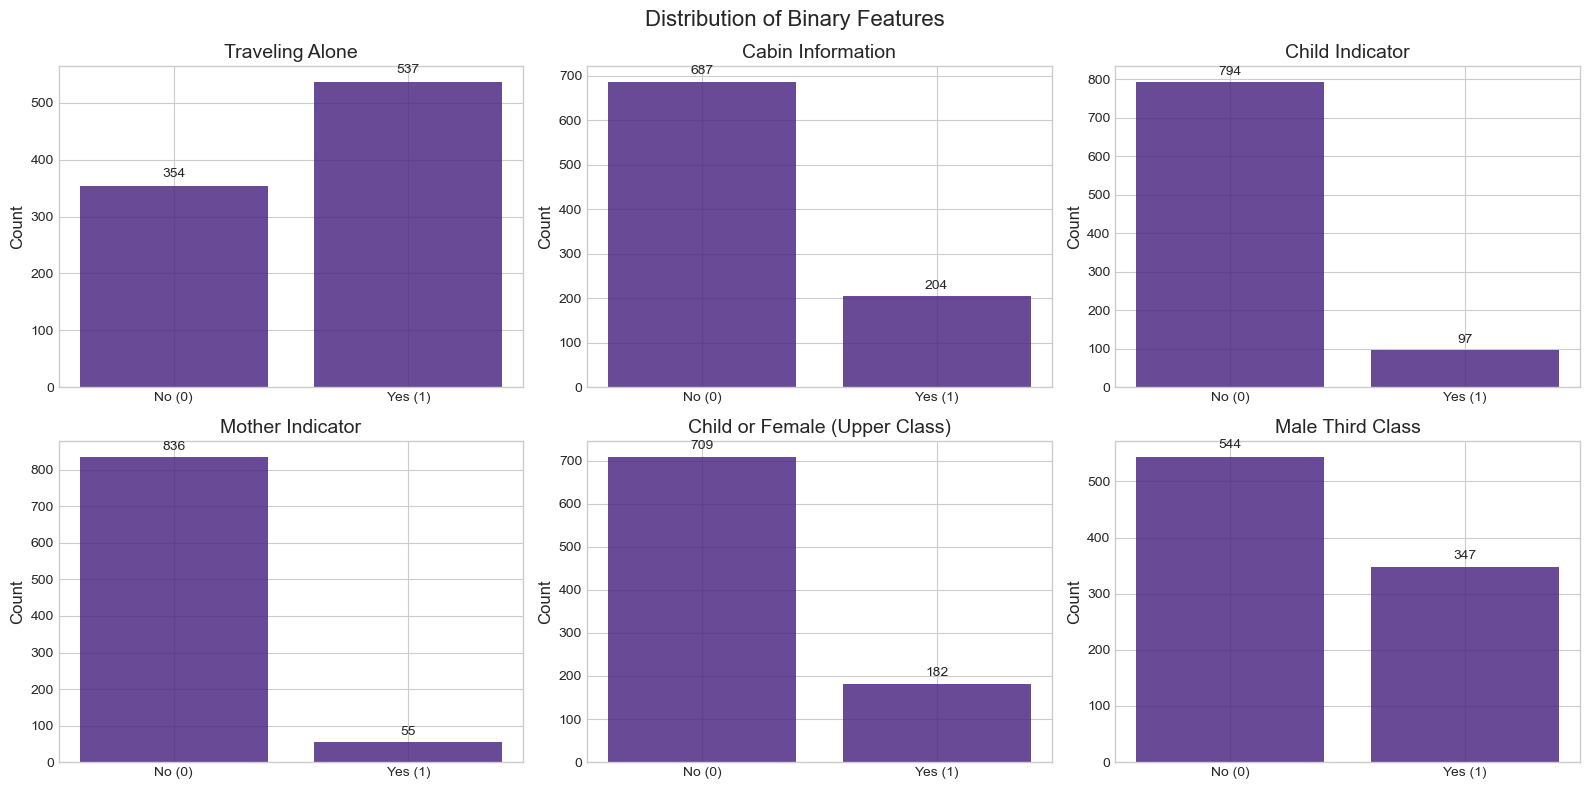

In [44]:
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

binary_features = {
    'IsAlone': 'Traveling Alone',
    'HasCabin': 'Cabin Information',
    'IsChild': 'Child Indicator',
    'IsMother': 'Mother Indicator',
    'ChildOrFemaleUpper': 'Child or Female (Upper Class)',
    'Male3rdClass': 'Male Third Class'
}

for ax, (feature, title) in zip(axes.flatten(), binary_features.items()):
    counts = df[feature].value_counts().sort_index()
    labels = ['No (0)', 'Yes (1)']
    
    bars = ax.bar(labels, counts.values, color=nu_purple, alpha=0.85)
    ax.set_title(title)
    ax.set_ylabel('Count')
    
    for bar in bars:
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 10,
            f"{int(bar.get_height())}",
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.suptitle('Distribution of Binary Features', fontsize=16)
plt.tight_layout()
plt.show()

These plots show the distribution of key binary features used in the models. Most passengers traveled alone and did not have cabin information, while fewer passengers fall into specific groups such as children or mothers. The interaction features highlight historically important survival patterns, such as higher-risk groups and protected groups, and confirm that these indicators are present in meaningful proportions.

## Feature Organization for Modeling
In this step, all engineered features are organized into numerical, categorical, and binary groups. No transformations are applied here. This organization step is used to clearly define how each feature will be handled in the preprocessing pipeline. Numerical features will be scaled, categorical features will be one-hot encoded, and binary features will be passed through as-is. Defining these groups before splitting ensures consistent preprocessing across the training, validation, and test datasets.

In [45]:
# Store processed dataframe
df_processed = df.copy()

# Numerical features
numeric_features = [
    'Age', 'Fare', 'SibSp', 'Parch', 'FamilySize',
    'FarePerPerson', 'NameLength', 'TicketGroupSize',
    'FamSurvRate', 'TktSurvRate',
    'Age_Pclass', 'FarePerPerson_Pclass', 'CabinCount'
]

# Categorical features 
categorical_features = [
    'Pclass', 'Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin',
    'FamilyGroup', 'Sex_Pclass', 'TicketPrefix', 'Deck'
]

# Binary features
binary_features = [
    'IsAlone', 'HasCabin', 'IsChild', 'IsMother',
    'ChildOrFemaleUpper', 'Male3rdClass', 'SexNum'
]

# Feature Set Summary Table

feature_summary = pd.DataFrame({
    'Feature Type': ['Numerical', 'Categorical', 'Binary'],
    'Number of Features': [
        len(numeric_features),
        len(categorical_features),
        len(binary_features)
    ],
    'Features': [
        ', '.join(numeric_features),
        ', '.join(categorical_features),
        ', '.join(binary_features)
    ]
})

display(
    nu_style_table(
        feature_summary,
        caption="Feature Sets Summary Before Encoding"
    )
)

,Feature Type,Number of Features,Features
0,Numerical,13,"Age, Fare, SibSp, Parch, FamilySize, FarePerPerson, NameLength, TicketGroupSize, FamSurvRate, TktSurvRate, Age_Pclass, FarePerPerson_Pclass, CabinCount"
1,Categorical,10,"Pclass, Sex, Embarked, Title, AgeBin, FareBin, FamilyGroup, Sex_Pclass, TicketPrefix, Deck"
2,Binary,7,"IsAlone, HasCabin, IsChild, IsMother, ChildOrFemaleUpper, Male3rdClass, SexNum"


Before encoding, the dataset has 30 features created from the original data. These are grouped into numerical, categorical, and binary features. Splitting the features this way makes it easier to prepare the data later, since numerical features will be scaled, categorical features will be encoded, and binary features can be used as they are. This step helps keep the preprocessing and modeling steps organized.

# Final EDA and Feature Selection
After completing preprocessing and feature engineering, a refined exploratory analysis was conducted to evaluate the usefulness of the selected features and to confirm that the engineered variables captured meaningful patterns related to survival. This step follows the CRISP-DM framework, where insights from earlier stages are revisited after data preparation.

Feature selection was guided by correlation analysis, survival rate comparisons, and interpretability. Gender, passenger class, and fare remained the strongest predictors of survival, while age showed weaker linear correlation but meaningful patterns when grouped. Family-related features and cabin availability were retained due to observable differences in survival outcomes. This refined EDA informed the final set of features used in the classification models.

## Overview of Cleaned Dataset
This quick check confirms the dataset shape, verifies that missing values have been handled, and shows a small preview of the engineered features to make sure everything looks correct before splitting and building the preprocessing pipeline.

In [46]:
# Dataset shape
shape_summary = pd.DataFrame({
    'Metric': ['Number of Rows', 'Number of Columns'],
    'Value': [df_processed.shape[0], df_processed.shape[1]]
})

display(
    nu_style_table(
        shape_summary,
        caption="Cleaned Dataset Shape"
    )
)

# Remaining missing values
remaining_missing = (
    df_processed.isnull()
    .sum()
    .reset_index()
    .rename(columns={'index': 'Feature', 0: 'Missing Count'})
)

remaining_missing = remaining_missing[remaining_missing['Missing Count'] > 0]

if len(remaining_missing) > 0:
    display(
        nu_style_table(
            remaining_missing,
            caption="Remaining Missing Values After Preprocessing"
        )
    )
else:
    no_missing_df = pd.DataFrame({
        'Status': ['No remaining missing values'],
        'Details': ['All features are complete after preprocessing']
    })

    display(
        nu_style_table(
            no_missing_df,
            caption="Missing Value Check After Preprocessing"
        )
    )


# Sample of Engineered Features 
sample_cols = [
    'PassengerId', 'Survived',

    # Core demographics
    'Pclass', 'Sex', 'Age', 'AgeBin', 'Title',

    # Family features
    'FamilySize', 'FamilyGroup', 'IsAlone', 'IsChild', 'IsMother', 'FamSurvRate',

    # Cabin features
    'HasCabin', 'Deck', 'CabinCount',

    # Ticket & fare features
    'TicketGroupSize', 'TicketPrefix', 'Fare', 'FarePerPerson', 'FareBin', 'TktSurvRate',

    # Interaction features
    'Sex_Pclass', 'Age_Pclass'
]

# Keep only columns that actually exist
sample_cols = [c for c in sample_cols if c in df_processed.columns]

display(
    nu_style_table(
        df_processed[sample_cols].head(10),
        caption="Sample of Processed Data with Engineered Features"
    )
)

,Metric,Value
0,Number of Rows,891
1,Number of Columns,37


,Feature,Missing Count
10,Cabin,687


,PassengerId,Survived,Pclass,Sex,Age,AgeBin,Title,FamilySize,FamilyGroup,IsAlone,IsChild,IsMother,FamSurvRate,HasCabin,Deck,CabinCount,TicketGroupSize,TicketPrefix,Fare,FarePerPerson,FareBin,TktSurvRate,Sex_Pclass,Age_Pclass
0,1,0,3,male,20.100000,YoungAdult,Mr,2,Small,0,0,0,0.000000,0,U,0,1,A5,7.250000,7.250000,Low,0.500000,male_3,60.300000
1,2,1,1,female,40.210000,Adult,Mrs,2,Small,0,0,0,0.500000,1,C,1,1,PC,71.283300,71.283300,High,0.500000,female_1,40.210000
2,3,1,3,female,25.130000,YoungAdult,Miss,1,Solo,1,0,0,0.500000,0,U,0,1,RARE,7.925000,7.925000,Medium_Low,0.500000,female_3,75.390000
3,4,1,1,female,36.440000,Adult,Mrs,2,Small,0,0,0,0.000000,1,C,1,2,NONE,53.100000,26.550000,High,0.000000,female_1,36.440000
4,5,0,3,male,36.440000,Adult,Mr,1,Solo,1,0,0,0.500000,0,U,0,1,NONE,8.050000,8.050000,Medium_Low,0.500000,male_3,109.320000
5,6,0,3,male,30.160000,YoungAdult,Mr,1,Solo,1,0,0,0.500000,0,U,0,1,NONE,8.458300,8.458300,Medium_Low,0.500000,male_3,90.480000
6,7,0,1,male,60.320000,Senior,Mr,1,Solo,1,0,0,0.500000,1,E,1,1,NONE,51.862500,51.862500,High,0.500000,male_1,60.320000
7,8,0,3,male,0.200000,Child,Master,5,Large,0,1,0,0.000000,0,U,0,4,NONE,21.075000,5.268750,Medium_High,0.000000,male_3,0.600000
8,9,1,3,female,26.380000,YoungAdult,Mrs,3,Small,0,0,1,0.400000,0,U,0,3,NONE,11.133300,3.711100,Medium_Low,1.000000,female_3,79.140000
9,10,1,2,female,10.050000,Child,Mrs,2,Small,0,1,0,0.000000,0,U,0,2,NONE,30.070800,15.035400,Medium_High,0.000000,female_2,20.100000


After preprocessing, the dataset still has 891 passengers, and now it has 34 columns because we added new engineered features. Most missing values are handled. The only column that still has lots of missing values is Cabin (687 missing), which is normal for this dataset. That is okay because we mainly use the HasCabin, Deck, and CabinCount features instead of relying on the raw Cabin text.

From the preview, the engineered features look correct and make sense (for example: AgeBin, FamilySize, FamilyGroup, IsAlone, FarePerPerson, FareBin, TicketGroupSize, and Sex_Pclass). Overall, the data looks ready to move on to the train/validation split and the model pipeline.

## Correlation Analysis
In this section, I examine the relationships between the target variable (Survived) and key numerical and binary features after feature engineering. Correlation values help show whether a feature has a positive or negative relationship with survival, and how strong that relationship is.

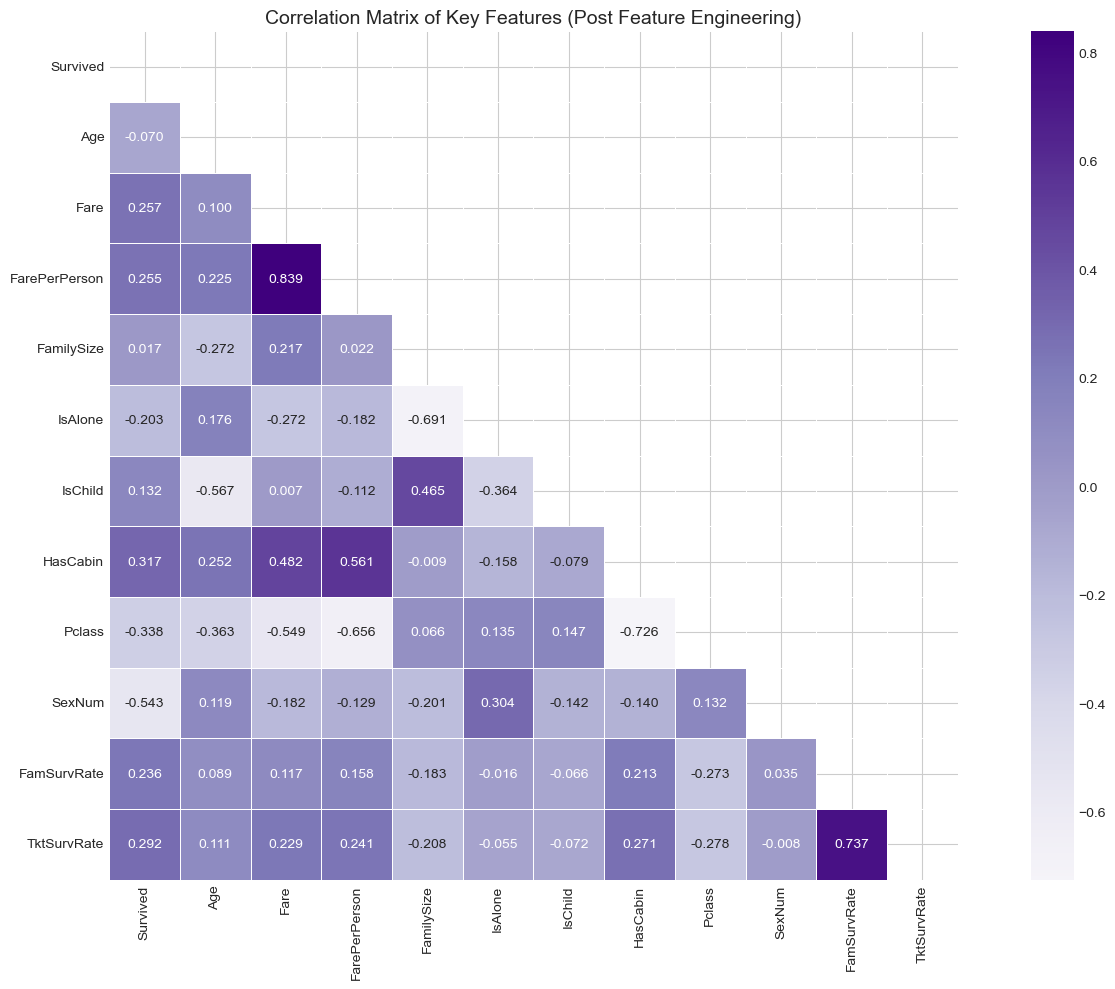

,Feature,Correlation with Survival
0,SexNum,-0.543000
1,Pclass,-0.338000
2,HasCabin,0.317000
3,TktSurvRate,0.292000
4,Fare,0.257000
5,FarePerPerson,0.255000
6,FamSurvRate,0.236000
7,IsAlone,-0.203000
8,IsChild,0.132000
9,Age,-0.070000


In [47]:
# key engineered features for correlation analysis
corr_features = [
    'Survived',
    'Age',
    'Fare',
    'FarePerPerson',
    'FamilySize',
    'IsAlone',
    'IsChild',
    'HasCabin',
    'Pclass',
    'SexNum', 
    'FamSurvRate',
    'TktSurvRate'
]

# Create correlation dataframe
corr_df = df_processed[corr_features]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Heatmap (upper triangle masked)
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".3f",
    cmap="Purples",
    center=0,
    square=True,
    linewidths=0.5,
    ax=ax
)

ax.set_title("Correlation Matrix of Key Features (Post Feature Engineering)")
plt.tight_layout()
plt.show()


# Sort correlations with Survived by absolute value
target_corr = (
    corr_matrix['Survived']
    .drop('Survived')
    .sort_values(key=abs, ascending=False)
)

corr_summary = pd.DataFrame({
    'Feature': target_corr.index,
    'Correlation with Survival': target_corr.values.round(3)
})

display(
    nu_style_table(
        corr_summary,
        caption="Feature Correlations with Survival (Sorted by Absolute Value)"
    )
)

The correlation results show that gender and passenger class are the strongest predictors of survival. Being male is strongly negatively correlated with survival, while lower passenger class is also linked to lower survival chances.

Features related to wealth and access, such as fare, fare per person, and having cabin information, show moderate positive correlations with survival. The ticket and family survival rate features also have positive correlations, which means passengers traveling with others who survived were more likely to survive themselves.

Age and family size have very weak correlations, suggesting they do not strongly affect survival on their own. Overall, these results match what was observed earlier in the exploratory analysis.

## Key Visualizations

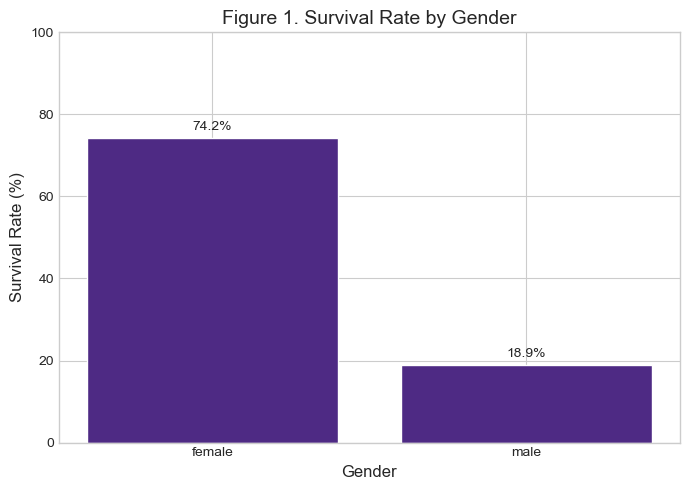

,Sex,Count,Survival Rate
0,female,314,74.2%
1,male,577,18.9%


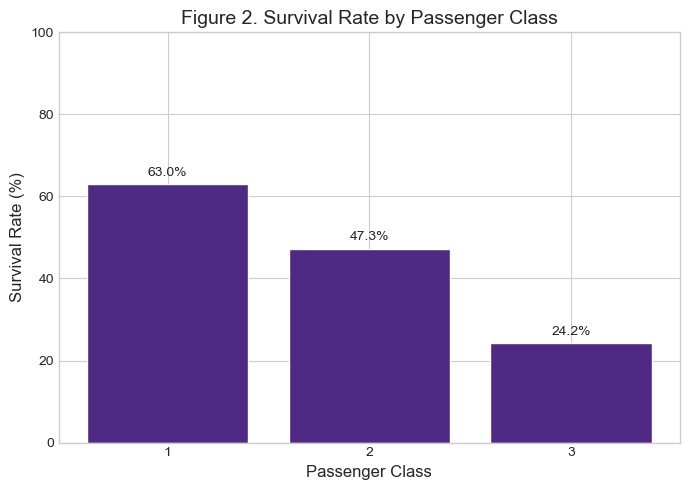

,Pclass,Count,Survival Rate
0,1,216,63.0%
1,2,184,47.3%
2,3,491,24.2%


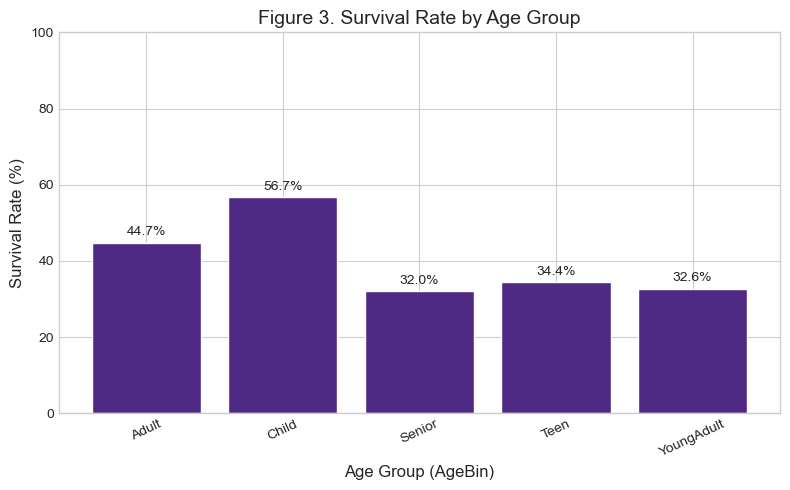

,AgeBin,Count,Survival Rate
0,Adult,219,44.7%
1,Child,97,56.7%
2,Senior,50,32.0%
3,Teen,96,34.4%
4,YoungAdult,429,32.6%


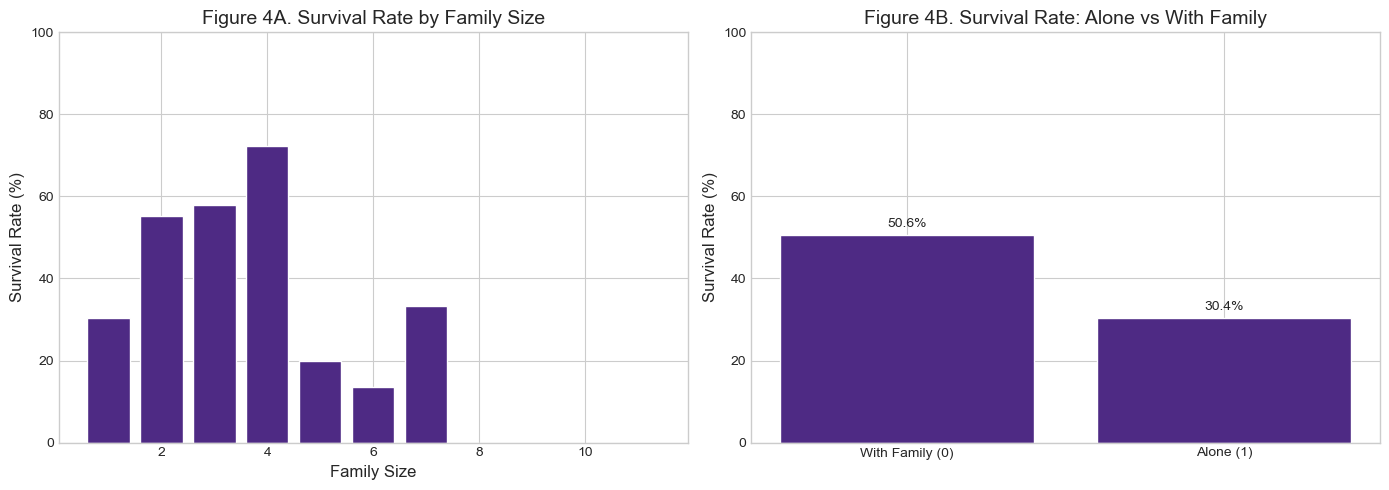

,IsAlone,Count,Survival Rate
0,0,354,50.6%
1,1,537,30.4%


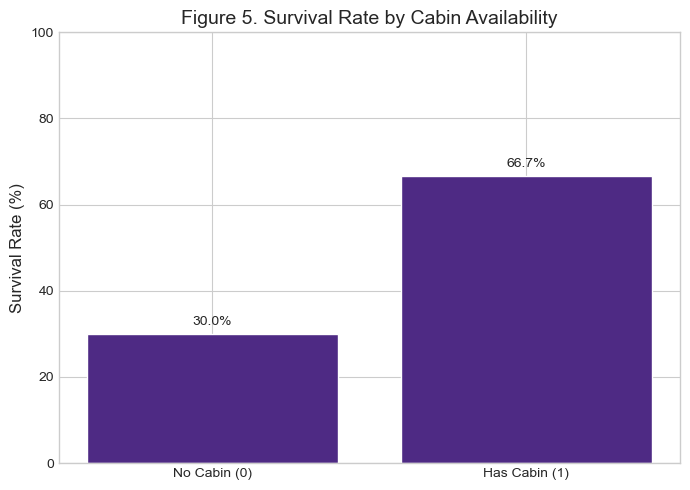

,HasCabin,Count,Survival Rate
0,0,687,30.0%
1,1,204,66.7%


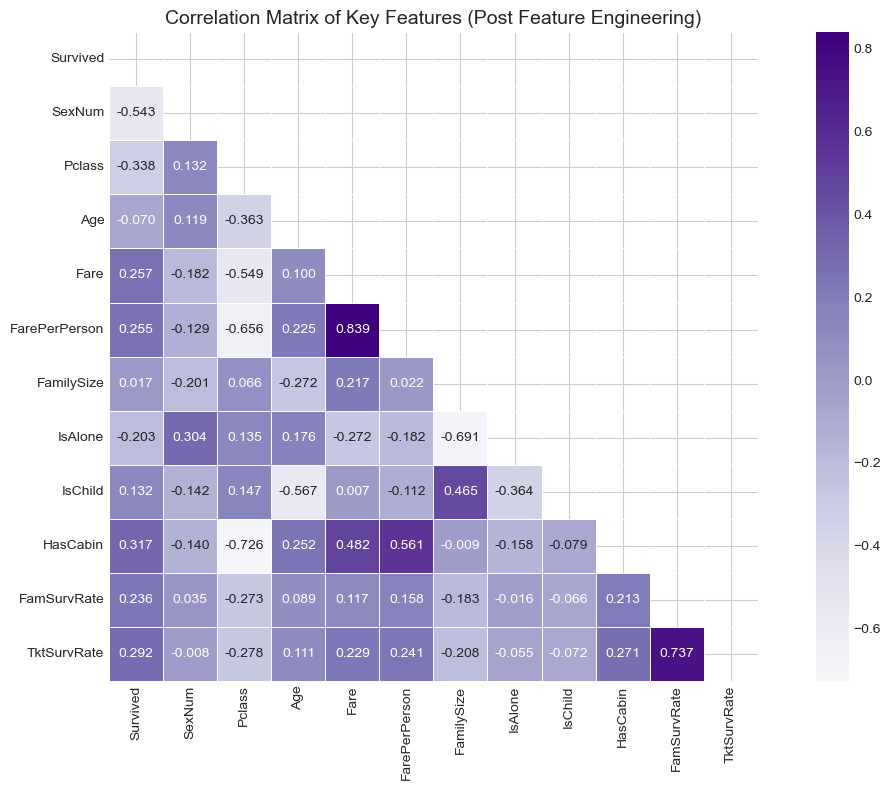

,Feature,Correlation with Survival
0,SexNum,-0.543000
1,Pclass,-0.338000
2,HasCabin,0.317000
3,TktSurvRate,0.292000
4,Fare,0.257000
5,FarePerPerson,0.255000
6,FamSurvRate,0.236000
7,IsAlone,-0.203000
8,IsChild,0.132000
9,Age,-0.070000


In [48]:
# Figure 1: Survival Rate by Gender (Sex)
sex_survival = df_processed.groupby('Sex')['Survived'].mean() * 100

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(sex_survival.index, sex_survival.values, color=nu_purple, edgecolor='white')
ax.set_title("Figure 1. Survival Rate by Gender")
ax.set_xlabel("Gender")
ax.set_ylabel("Survival Rate (%)")
ax.set_ylim(0, 100)

for i, v in enumerate(sex_survival.values):
    ax.text(i, v + 2, f"{v:.1f}%", ha="center")

plt.tight_layout()
plt.show()

survival_rate_table(df_processed, "Sex", "Table: Survival Rate by Gender")


# Figure 2: Survival Rate by Passenger Class (Pclass)
pclass_survival = df_processed.groupby('Pclass')['Survived'].mean() * 100

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(pclass_survival.index.astype(str), pclass_survival.values, color=nu_purple, edgecolor='white')
ax.set_title("Figure 2. Survival Rate by Passenger Class")
ax.set_xlabel("Passenger Class")
ax.set_ylabel("Survival Rate (%)")
ax.set_ylim(0, 100)

for i, v in enumerate(pclass_survival.values):
    ax.text(i, v + 2, f"{v:.1f}%", ha="center")

plt.tight_layout()
plt.show()

survival_rate_table(df_processed, "Pclass", "Table: Survival Rate by Passenger Class")

# Figure 3: Survival Rate by Age Group (AgeBin)
agebin_survival = df_processed.groupby('AgeBin')['Survived'].mean() * 100

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(agebin_survival.index.astype(str), agebin_survival.values, color=nu_purple, edgecolor='white')
ax.set_title("Figure 3. Survival Rate by Age Group")
ax.set_xlabel("Age Group (AgeBin)")
ax.set_ylabel("Survival Rate (%)")
ax.set_ylim(0, 100)
ax.tick_params(axis='x', rotation=25)

for i, v in enumerate(agebin_survival.values):
    ax.text(i, v + 2, f"{v:.1f}%", ha="center")

plt.tight_layout()
plt.show()

survival_rate_table(df_processed, "AgeBin", "Table: Survival Rate by Age Group")

# Figure 4: FamilySize + IsAlone (Engineered Features)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# FamilySize survival
family_survival = df_processed.groupby('FamilySize')['Survived'].mean() * 100
axes[0].bar(family_survival.index, family_survival.values, color=nu_purple, edgecolor='white')
axes[0].set_title("Figure 4A. Survival Rate by Family Size")
axes[0].set_xlabel("Family Size")
axes[0].set_ylabel("Survival Rate (%)")
axes[0].set_ylim(0, 100)

# IsAlone survival
alone_survival = df_processed.groupby('IsAlone')['Survived'].mean() * 100
labels = ['With Family (0)', 'Alone (1)']
bars = axes[1].bar(labels, alone_survival.values, color=nu_purple, edgecolor='white')
axes[1].set_title("Figure 4B. Survival Rate: Alone vs With Family")
axes[1].set_ylabel("Survival Rate (%)")
axes[1].set_ylim(0, 100)

for bar, v in zip(bars, alone_survival.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, v + 2, f"{v:.1f}%", ha="center")

plt.tight_layout()
plt.show()

survival_rate_table(df_processed, "IsAlone", "Table: Survival Rate by IsAlone")

# Figure 5: Survival Rate by Cabin Availability (HasCabin)
cabin_survival = df_processed.groupby('HasCabin')['Survived'].mean() * 100

fig, ax = plt.subplots(figsize=(7, 5))
labels = ['No Cabin (0)', 'Has Cabin (1)']
bars = ax.bar(labels, cabin_survival.values, color=nu_purple, edgecolor='white')
ax.set_title("Figure 5. Survival Rate by Cabin Availability")
ax.set_ylabel("Survival Rate (%)")
ax.set_ylim(0, 100)

for bar, v in zip(bars, cabin_survival.values):
    ax.text(bar.get_x() + bar.get_width()/2, v + 2, f"{v:.1f}%", ha="center")

plt.tight_layout()
plt.show()

survival_rate_table(df_processed, "HasCabin", "Table: Survival Rate by HasCabin")

# Correlation Analysis (Key Features) + Table
corr_features = [
    'Survived', 'SexNum', 'Pclass', 'Age', 'Fare', 'FarePerPerson',
    'FamilySize', 'IsAlone', 'IsChild', 'HasCabin', 'FamSurvRate', 'TktSurvRate'
]

corr_features = [c for c in corr_features if c in df_processed.columns]
corr_df = df_processed[corr_features].copy()
corr_matrix = corr_df.corr()

fig, ax = plt.subplots(figsize=(12, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".3f",
    cmap="Purples",
    center=0,
    square=True,
    linewidths=0.5,
    ax=ax
)

ax.set_title("Correlation Matrix of Key Features (Post Feature Engineering)")
plt.tight_layout()
plt.show()

# Correlation with target
target_corr = (
    corr_matrix['Survived']
    .drop('Survived')
    .sort_values(key=abs, ascending=False)
)

corr_summary = pd.DataFrame({
    'Feature': target_corr.index,
    'Correlation with Survival': target_corr.values.round(3)
})

display(
    nu_style_table(
        corr_summary,
        caption="Table: Feature Correlations with Survival (Sorted by Absolute Value)"
    )
)

## Feature Importance Analysis using L1 Regularization (Lasso)
This section uses Logistic Regression with an L1 (Lasso) penalty to identify which features are most important for predicting survival. Lasso shrinks weak feature coefficients toward zero, which helps with feature selection and model interpretability.

Each feature has a coefficient, which shows the direction of its effect on survival (positive values increase survival probability, while negative values decrease it). The absolute coefficient measures the strength of the effect, regardless of direction, and is used to rank feature importance. Larger absolute values indicate more influential features. Because Lasso is sensitive to scale, all features are standardized before fitting the model (James et al. 2013).

Feature Importance (L1-Regularized Logistic Regression):


,Feature,Coefficient,Abs_Coefficient
17,Sex_Pclass_encoded,-1.372500,1.372500
16,FamilyGroup_encoded,1.367600,1.367600
8,IsAlone,-1.002300,1.002300
14,NameLength,0.383800,0.383800
2,Age,-0.288400,0.288400
9,HasCabin,0.269000,0.269000
19,IsChild,0.235400,0.235400
10,Title_encoded,-0.233600,0.233600
5,Fare,0.206200,0.206200
6,Embarked_encoded,-0.167900,0.167900


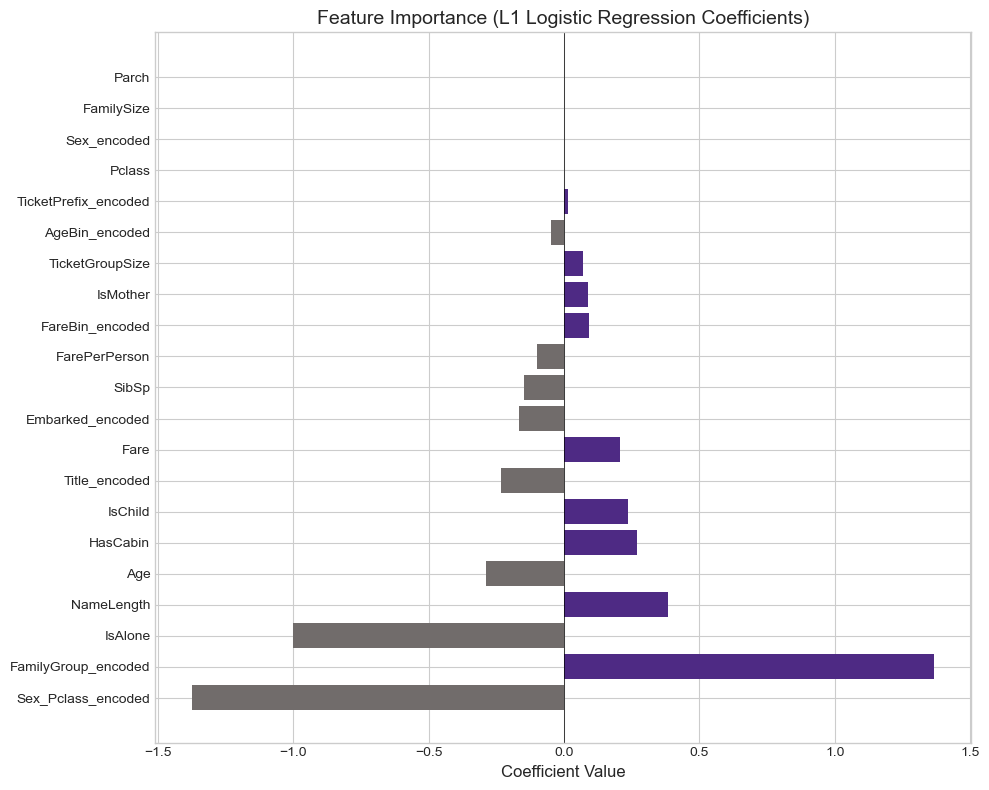


Features with zero coefficients (eliminated by L1):
['Sex_encoded', 'FamilySize', 'Parch']


In [49]:
df_analysis = df_processed.copy()

# Encode categorical variables for importance analysis
le = LabelEncoder()
df_analysis['Sex_encoded'] = le.fit_transform(df_analysis['Sex'])
df_analysis['Embarked_encoded'] = le.fit_transform(df_analysis['Embarked'].fillna('S'))
df_analysis['Title_encoded'] = le.fit_transform(df_analysis['Title'])
df_analysis['AgeBin_encoded'] = le.fit_transform(df_analysis['AgeBin'].astype(str))
df_analysis['FareBin_encoded'] = le.fit_transform(df_analysis['FareBin'].astype(str))
df_analysis['FamilyGroup_encoded'] = le.fit_transform(df_analysis['FamilyGroup'])
df_analysis['Sex_Pclass_encoded'] = le.fit_transform(df_analysis['Sex_Pclass'])
df_analysis['TicketPrefix_encoded'] = le.fit_transform(df_analysis['TicketPrefix'])

# Features for importance analysis 
importance_features = ['Pclass', 'Sex_encoded', 'Age', 'SibSp', 'Parch', 'Fare', 
                       'Embarked_encoded', 'FamilySize', 'IsAlone', 'HasCabin',
                       'Title_encoded', 'AgeBin_encoded', 'FareBin_encoded',
                       'FarePerPerson', 'NameLength', 'TicketGroupSize',
                       'FamilyGroup_encoded', 'Sex_Pclass_encoded', 
                       'TicketPrefix_encoded', 'IsChild', 'IsMother']

X_importance = df_analysis[importance_features].values
y_importance = df_analysis['Survived'].values

# Fit Logistic Regression with L1 penalty (Lasso) for feature selection
scaler_temp = StandardScaler()
X_importance_scaled = scaler_temp.fit_transform(X_importance)

lasso_model = LogisticRegression(penalty='l1', solver='liblinear', C=1.0, random_state=42)
lasso_model.fit(X_importance_scaled, y_importance)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': importance_features,
    'Coefficient': lasso_model.coef_[0],
    'Abs_Coefficient': np.abs(lasso_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("Feature Importance (L1-Regularized Logistic Regression):")
display(nu_style_table(feature_importance.round(4), caption="Feature Importance Rankings"))

# Visualize
fig, ax = plt.subplots(figsize=(10, 8))
colors = [nu_purple if c > 0 else nu_dark_gray for c in feature_importance['Coefficient']]
ax.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
ax.set_xlabel('Coefficient Value')
ax.set_title('Feature Importance (L1 Logistic Regression Coefficients)')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

print(f"\nFeatures with zero coefficients (eliminated by L1):")
zero_features = feature_importance[feature_importance['Abs_Coefficient'] == 0]['Feature'].tolist()
print(zero_features if zero_features else "None - all features retained")

The L1 logistic regression results show that group-based and interaction features are the strongest predictors of survival. FamilyGroup and Sex_Pclass have the largest coefficients, indicating that survival depended heavily on who passengers traveled with and how gender interacted with passenger class.

Traveling alone has a clear negative effect on survival, as shown by the strong coefficient for IsAlone. Age and NameLength contribute to prediction but have a smaller impact compared to group-related features. Variables such as HasCabin and TicketGroupSize add useful information, though they are not dominant predictors.

Some baseline variables, including Sex_encoded, FamilySize, and Parch, were reduced to zero by the L1 penalty. This suggests that once engineered and interaction features were included, these original variables no longer provided additional predictive value. Overall, the results confirm that feature engineering captured survival patterns more effectively than relying on the original variables alone.

## Age Analysis
This section examines how age affects survival on the Titanic. The visualizations show that younger passengers, especially children, had higher survival rates, while older passengers were less likely to survive. This pattern is consistent across the age distribution plots, age bins, and survival counts, and supports the historical priority given to children during evacuation.

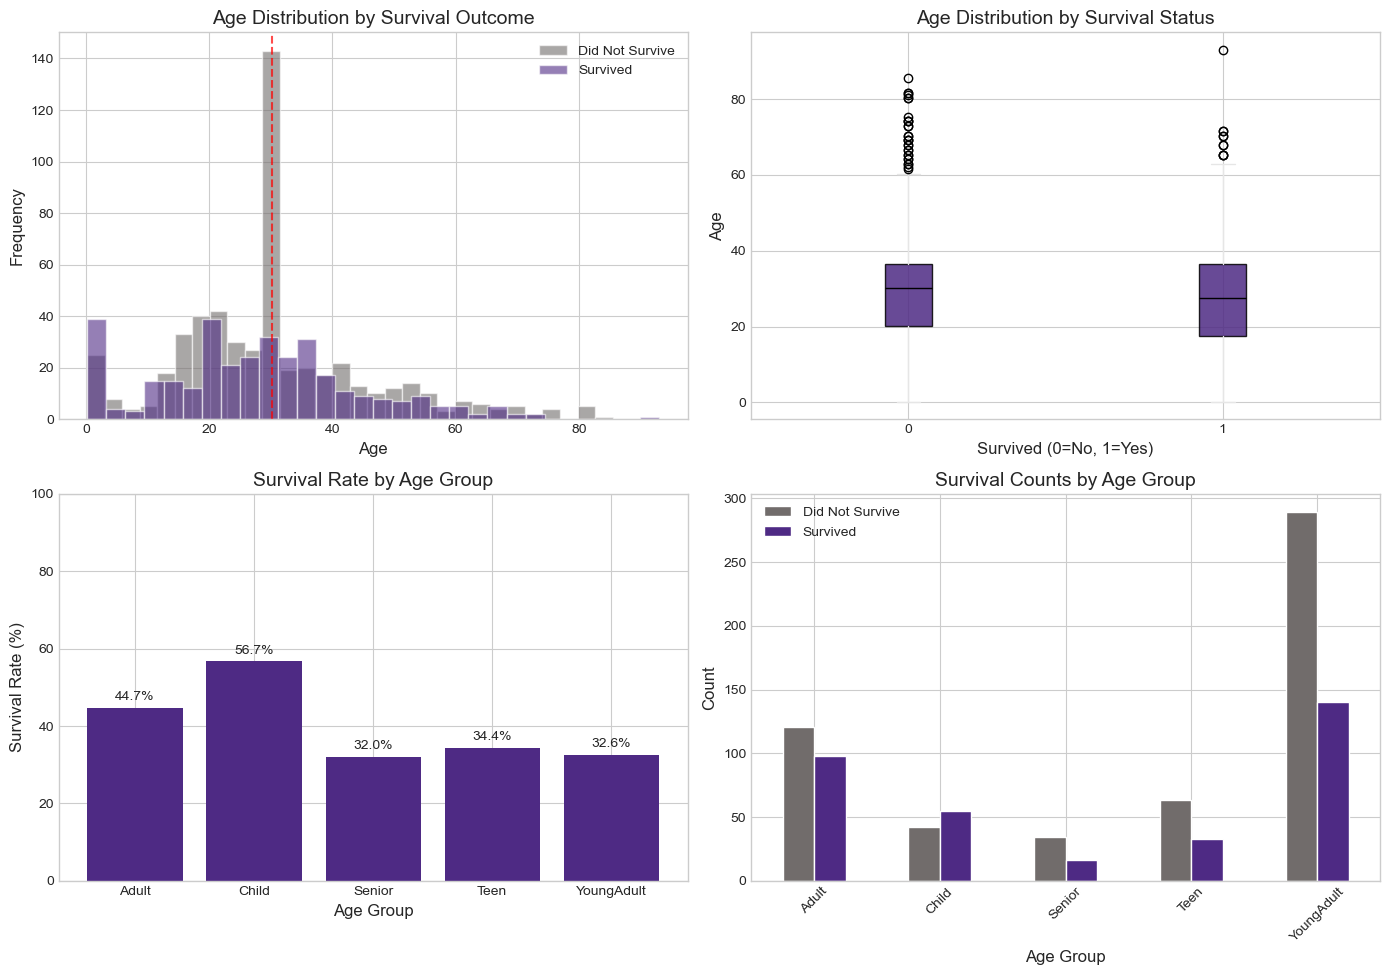

Survived,0,1
count,549.000000,342.000000
mean,30.370000,28.010000
std,15.910000,17.080000
min,0.200000,0.200000
25%,20.100000,17.590000
50%,30.160000,27.640000
75%,36.440000,36.440000
max,85.460000,93.000000


In [50]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Age Distribution by Survival
ax1 = axes[0, 0]
for survived, color, label in [(0, nu_dark_gray, 'Did Not Survive'), (1, nu_purple, 'Survived')]:
    data = df_processed[df_processed['Survived'] == survived]['Age']
    ax1.hist(data, bins=30, alpha=0.6, color=color, label=label, edgecolor='white')
ax1.set_xlabel('Age')
ax1.set_ylabel('Frequency')
ax1.set_title('Age Distribution by Survival Outcome')
ax1.legend()
ax1.axvline(df_processed['Age'].median(), color='red', linestyle='--', alpha=0.7, label='Median')

# Age Boxplot by Survival
ax2 = axes[0, 1]
df_processed.boxplot(column='Age', by='Survived', ax=ax2,
                     patch_artist=True,
                     boxprops=dict(facecolor=nu_purple, alpha=0.85),
                     medianprops=dict(color="black"),
                     whiskerprops=dict(color=nu_gray),
                     capprops=dict(color=nu_gray)
)
ax2.set_xlabel('Survived (0=No, 1=Yes)')
ax2.set_ylabel('Age')
ax2.set_title('Age Distribution by Survival Status')
plt.suptitle('')



# Survival Rate by Age Bin
ax3 = axes[1, 0]
age_survival = df_processed.groupby('AgeBin')['Survived'].mean() * 100
bars = ax3.bar(age_survival.index, age_survival.values, color=nu_purple)
ax3.set_xlabel('Age Group')
ax3.set_ylabel('Survival Rate (%)')
ax3.set_title('Survival Rate by Age Group')
ax3.set_ylim(0, 100)
for bar, rate in zip(bars, age_survival.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{rate:.1f}%', ha='center')

# Count by Age Bin and Survival
ax4 = axes[1, 1]
age_counts = df_processed.groupby(['AgeBin', 'Survived']).size().unstack(fill_value=0)
age_counts.plot(kind='bar', ax=ax4, color=[nu_dark_gray, nu_purple], edgecolor='white')
ax4.set_xlabel('Age Group')
ax4.set_ylabel('Count')
ax4.set_title('Survival Counts by Age Group')
ax4.legend(['Did Not Survive', 'Survived'])
ax4.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statistics
display(nu_style_table(df_processed.groupby('Survived')['Age'].describe().round(2).T, 
                       caption="Age Descriptive Statistics"))

From the plots, age has some effect on survival, but it is not very strong overall. Survivors are a little younger on average than non-survivors, but the age ranges overlap a lot. The clearest difference is for children, who have the highest survival rate, which matches what we expect from the “women and children first” rule. For most adults, age by itself does not clearly separate who survived and who did not.

## Additional Variables Analysis (Fare, SibSp, Parch, Embarked)
This section examines how fare, family connections, and embarkation port relate to survival. Passengers who paid higher fares generally had higher survival rates. Survival also varies by family structure and by the port where passengers boarded the ship, suggesting these factors played a role during evacuation.

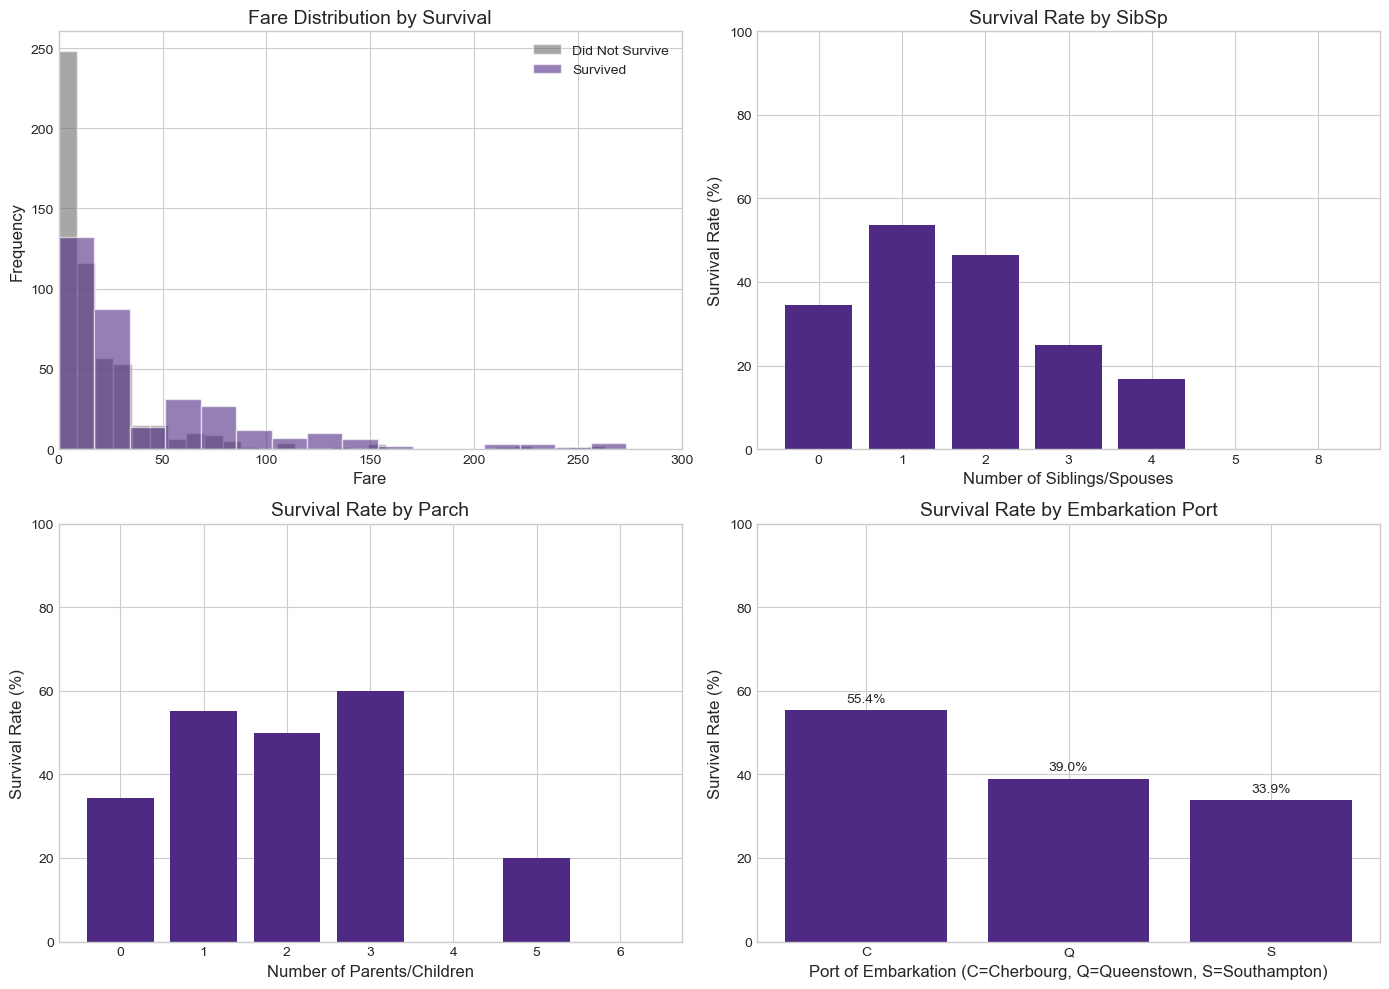

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Fare Distribution by Survival
ax1 = axes[0, 0]
for survived, color, label in [(0, nu_dark_gray, 'Did Not Survive'), (1, nu_purple, 'Survived')]:
    data = df_processed[df_processed['Survived'] == survived]['Fare']
    ax1.hist(data, bins=30, alpha=0.6, color=color, label=label, edgecolor='white')
ax1.set_xlabel('Fare')
ax1.set_ylabel('Frequency')
ax1.set_title('Fare Distribution by Survival')
ax1.legend()
ax1.set_xlim(0, 300)

# SibSp Survival Rate
ax2 = axes[0, 1]
sibsp_survival = df_processed.groupby('SibSp')['Survived'].mean() * 100
ax2.bar(sibsp_survival.index.astype(str), sibsp_survival.values, color=nu_purple)
ax2.set_xlabel('Number of Siblings/Spouses')
ax2.set_ylabel('Survival Rate (%)')
ax2.set_title('Survival Rate by SibSp')
ax2.set_ylim(0, 100)

# Parch Survival Rate
ax3 = axes[1, 0]
parch_survival = df_processed.groupby('Parch')['Survived'].mean() * 100
ax3.bar(parch_survival.index.astype(str), parch_survival.values, color=nu_purple)
ax3.set_xlabel('Number of Parents/Children')
ax3.set_ylabel('Survival Rate (%)')
ax3.set_title('Survival Rate by Parch')
ax3.set_ylim(0, 100)

# Embarked Survival Rate
ax4 = axes[1, 1]
embarked_survival = df_processed.groupby('Embarked')['Survived'].mean() * 100
bars = ax4.bar(embarked_survival.index, embarked_survival.values, color=nu_purple)
ax4.set_xlabel('Port of Embarkation (C=Cherbourg, Q=Queenstown, S=Southampton)')
ax4.set_ylabel('Survival Rate (%)')
ax4.set_title('Survival Rate by Embarkation Port')
ax4.set_ylim(0, 100)
for bar, rate in zip(bars, embarked_survival.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{rate:.1f}%', ha='center')

plt.tight_layout()
plt.show()

The plots show clear patterns between survival and these variables. Passengers who paid higher fares were more likely to survive, while most non-survivors are concentrated in the lowest fare range. Survival is highest for passengers traveling with one or two siblings or spouses, and it drops as family size increases. A similar pattern appears for parents and children, where small family groups have better outcomes than very large ones. Survival also differs by embarkation port, with Cherbourg showing the highest survival rate compared to Southampton and Queenstown.

## Engineered Features Analysis (FamilySize, IsAlone, HasCabin, Title)
This section visualizes several engineered features to examine how survival rates vary by family size, whether a passenger traveled alone, cabin availability, and passenger title.

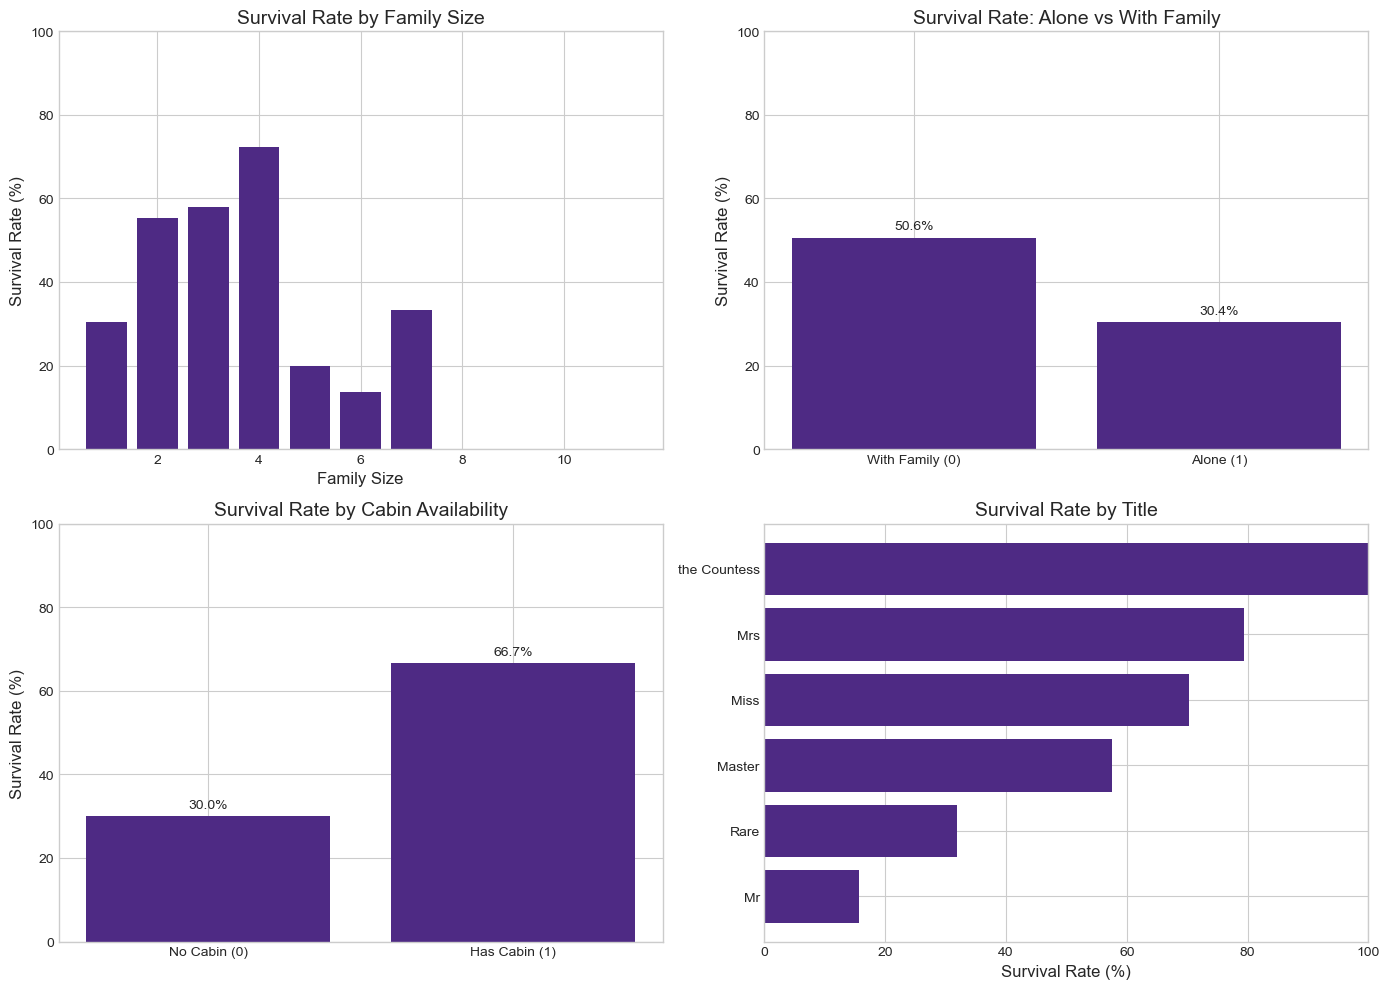

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# FamilySize Survival Rate
ax1 = axes[0, 0]
family_survival = df_processed.groupby('FamilySize')['Survived'].mean() * 100
ax1.bar(family_survival.index, family_survival.values, color=nu_purple)
ax1.set_xlabel('Family Size')
ax1.set_ylabel('Survival Rate (%)')
ax1.set_title('Survival Rate by Family Size')
ax1.set_ylim(0, 100)

# IsAlone Survival Rate
ax2 = axes[0, 1]
alone_survival = df_processed.groupby('IsAlone')['Survived'].mean() * 100
bars = ax2.bar(['With Family (0)', 'Alone (1)'], alone_survival.values, color=nu_purple)
ax2.set_ylabel('Survival Rate (%)')
ax2.set_title('Survival Rate: Alone vs With Family')
ax2.set_ylim(0, 100)
for bar, rate in zip(bars, alone_survival.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{rate:.1f}%', ha='center')

# HasCabin Survival Rate
ax3 = axes[1, 0]
cabin_survival = df_processed.groupby('HasCabin')['Survived'].mean() * 100
bars = ax3.bar(['No Cabin (0)', 'Has Cabin (1)'], cabin_survival.values, color=nu_purple)
ax3.set_ylabel('Survival Rate (%)')
ax3.set_title('Survival Rate by Cabin Availability')
ax3.set_ylim(0, 100)
for bar, rate in zip(bars, cabin_survival.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, f'{rate:.1f}%', ha='center')

# Title Survival Rate
ax4 = axes[1, 1]
title_survival = df_processed.groupby('Title')['Survived'].mean() * 100
title_survival = title_survival.sort_values(ascending=True)
ax4.barh(title_survival.index, title_survival.values, color=nu_purple)
ax4.set_xlabel('Survival Rate (%)')
ax4.set_title('Survival Rate by Title')
ax4.set_xlim(0, 100)

plt.tight_layout()
plt.show()

The plots show how survival rates change based on family size, whether a passenger traveled alone, cabin availability, and passenger title. These engineered features help summarize social and travel-related patterns in the data and give a clearer view of how different passenger groups experienced the disaster.

## Feature Selection Summary
Feature selection is based on the results from the L1-regularized Logistic Regression and the correlation analysis of thirteen main variables. These methods help show which features are most useful for predicting survival, while also checking whether any variables add very little information. The purpose of this step is mainly to understand feature importance, not to aggressively remove variables.

Gender is the strongest predictor of survival in the dataset. Female passengers had much higher survival rates than males, which matches what is known about the evacuation process. Passenger title is also important because it captures both gender and social role, with titles such as Mrs and Miss linked to higher survival. Passenger class and fare both show strong relationships with survival, where higher class and higher fares are associated with better outcomes. Age matters most for children, while differences among adults are smaller, which is why age groups are more useful than raw age values.

The engineered features clearly add value. Family size and the IsAlone indicator capture group effects, showing that passengers traveling with family were more likely to survive than those traveling alone. The HasCabin feature is also useful, even though many cabin values are missing, because simply knowing whether a cabin was recorded is strongly related to survival.

All thirteen features are kept for the modeling stage. Different models may use different patterns in the data, so keeping a broader set of meaningful features allows for more flexible and accurate modeling. This approach follows the CRISP-DM process by using both exploratory analysis and model-based results to guide feature selection.

# Validation Splitting and Preprocessing
This section prepares the dataset for modeling by selecting the final features, splitting the data into training and validation sets, and applying a preprocessing pipeline.

## Feature Matrix Preparation
All engineered features are combined into a single feature matrix. The target variable is survival status. Features are grouped into numerical, categorical, and binary sets, which will later be handled differently in the preprocessing pipeline.

In [53]:
model_features = numeric_features + categorical_features + binary_features

X = df_processed[model_features].copy()
y = df_processed['Survived'].copy()

print(f"Features selected: {len(model_features)}")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Features selected: 30
X shape: (891, 30)
y shape: (891,)


## Train–Validation Split
The data is split into 70% training and 30% validation sets. Stratified sampling is used to preserve the original survival rate in both sets, which is important due to class imbalance in the target variable.

In [54]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.30,
    stratify=y,
    random_state=random_state
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")

Training set: 623 samples (69.9%)
Validation set: 268 samples (30.1%)


The data was split almost exactly as planned. About 70% of the passengers (623 samples) are used for training the models, while the remaining 30% (268 samples) are kept for validation. This gives the models enough data to learn from while still leaving a separate set to fairly evaluate performance.

To confirm that stratification worked as expected, survival counts and rates are compared across the two splits.

In [55]:
split_summary = pd.DataFrame({
    'Set': ['Training', 'Validation'],
    'Total': [len(y_train), len(y_val)],
    'Survived': [y_train.sum(), y_val.sum()],
    'Survival Rate': [f"{y_train.mean()*100:.1f}%", f"{y_val.mean()*100:.1f}%"]
})

display(nu_style_table(split_summary, caption="Train/Validation Split Summary"))

,Set,Total,Survived,Survival Rate
0,Training,623,239,38.4%
1,Validation,268,103,38.4%


The training and validation sets have the same survival rate (38.4%), so the split looks correct. Using a stratified split helps make sure both sets represent the original data well. This is important so the model is tested fairly and the results are not biased by an uneven class distribution.

## Preprocessing Pipeline
In this step, a preprocessing pipeline is created to make sure the training and validation data are treated in the same way. Numerical features are scaled using StandardScaler so they are on a similar scale, which helps models like Logistic Regression and KNN. Categorical features are converted into numeric form using one-hot encoding so the models can use them properly. Binary features are passed through as they are, since they are already represented as 0 and 1.

In [56]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('bin', 'passthrough', binary_features)
    ]
)
X_train_prepared = preprocessor.fit_transform(X_train)
X_val_prepared = preprocessor.transform(X_val)

print(f"Preprocessed training data shape: {X_train_prepared.shape}")
print(f"Preprocessed validation data shape: {X_val_prepared.shape}")

Preprocessed training data shape: (623, 69)
Preprocessed validation data shape: (268, 69)


After applying the preprocessing pipeline, the training set contains 623 rows with 70 transformed features, and the validation set contains 268 rows with the same 70 features.
This shows that encoding and scaling worked correctly and that both datasets now have the same structure, which is required before training and evaluating the classification models.

## Feature Groups Used for Modeling
For clarity and reproducibility, the final feature sets are summarized below.

In [57]:
# Feature Sets Summary (Before Encoding)

feature_sets_summary = pd.DataFrame({
    'Feature Type': ['Numerical', 'Categorical', 'Binary'],
    'Number of Features': [
        len(numeric_features),
        len(categorical_features),
        len(binary_features)
    ],
    'Features': [
        ', '.join(numeric_features),
        ', '.join(categorical_features),
        ', '.join(binary_features)
    ]
})

display(
    nu_style_table(
        feature_sets_summary,
        caption="Feature Sets Summary Before Encoding"
    )
)

# Total feature count
total_features = len(numeric_features) + len(categorical_features) + len(binary_features)

total_summary = pd.DataFrame({
    'Metric': ['Total Features Before Encoding'],
    'Value': [total_features]
})

display(
    nu_style_table(
        total_summary,
        caption="Total Feature Count"
    )
)

,Feature Type,Number of Features,Features
0,Numerical,13,"Age, Fare, SibSp, Parch, FamilySize, FarePerPerson, NameLength, TicketGroupSize, FamSurvRate, TktSurvRate, Age_Pclass, FarePerPerson_Pclass, CabinCount"
1,Categorical,10,"Pclass, Sex, Embarked, Title, AgeBin, FareBin, FamilyGroup, Sex_Pclass, TicketPrefix, Deck"
2,Binary,7,"IsAlone, HasCabin, IsChild, IsMother, ChildOrFemaleUpper, Male3rdClass, SexNum"


,Metric,Value
0,Total Features Before Encoding,30


## Multicollinearity Check (Logistic Regression Assumption)
To check for multicollinearity among numerical features, Variance Inflation Factors (VIF) are calculated using the scaled training data. This step is important for Logistic Regression, which assumes limited correlation among predictors.

In [58]:
n_num = len(numeric_features)
X_train_num_scaled = X_train_prepared[:, :n_num]

vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_features
vif_data['VIF'] = [
    variance_inflation_factor(X_train_num_scaled, i)
    for i in range(n_num)
]

display(nu_style_table(vif_data.round(2), caption="Variance Inflation Factors (Multicollinearity Check)"))

,Feature,VIF
0,Age,3.670000
1,Fare,7.300000
2,SibSp,inf
3,Parch,inf
4,FamilySize,inf
5,FarePerPerson,106.230000
6,NameLength,1.220000
7,TicketGroupSize,3.700000
8,FamSurvRate,2.250000
9,TktSurvRate,2.410000


The VIF results show that some numerical features are highly related to each other. This is expected because several variables were created from the same information, such as FamilySize from SibSp and Parch, and FarePerPerson from Fare. These relationships cause high VIF values. While this can affect Logistic Regression coefficients, it is less of an issue for the other models used in this project. For this reason, all features are kept, and regularization is used later to handle multicollinearity.

# Model Building and Evaluation
In this section, I train and compare the required classification models using the same train/validation split and the same preprocessing pipeline. To keep the comparison fair, I use stratified cross-validation for tuning and then report performance on the held-out validation set. Logistic Regression is used as a strong baseline, LDA is a probabilistic linear classifier, and KNN is a distance-based model. (James et al. 2013)

## Cross-Validation Setup
This sets up 10-fold stratified cross-validation so each fold keeps a similar survival percentage. This gives a more stable estimate during tuning.

In [59]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

# Storage for results
all_results = []
trained_models = {}

## Model 1: Logistic Regression
Logistic Regression is a simple and interpretable baseline for binary classification. It works well when the relationship between features and the outcome is mostly linear (in log-odds). (James et al. 2013)

### Baseline Logistic Regression (CV check)

In [60]:
log_reg_baseline = LogisticRegression(max_iter=1000, random_state=random_state)
log_reg_baseline.fit(X_train_prepared, y_train)

cv_scores_logreg = cross_val_score(
    log_reg_baseline,
    X_train_prepared,
    y_train,
    cv=cv,
    scoring="roc_auc"
)

logreg_cv_summary = pd.DataFrame({
    "Metric": ["Mean CV ROC-AUC", "Std (x2)"],
    "Value": [cv_scores_logreg.mean(), cv_scores_logreg.std() * 2]
})

display(nu_style_table(logreg_cv_summary.round(4), caption="Logistic Regression Baseline - CV ROC-AUC"))

,Metric,Value
0,Mean CV ROC-AUC,0.889700
1,Std (x2),0.080000


### Hyperparameter Tuning (GridSearchCV)

In [61]:
logreg_param_grid = {
    "C": np.logspace(-3, 2, 50).tolist(),
    "penalty": ["l1", "l2"],
    "solver": ["liblinear"]
}

log_reg_grid = GridSearchCV(
    LogisticRegression(max_iter=10000, random_state=random_state),
    logreg_param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=0
)

log_reg_grid.fit(X_train_prepared, y_train)

best_logreg_summary = pd.DataFrame({
    "Metric": ["Best Parameters", "Best CV Accuracy"],
    "Value": [str(log_reg_grid.best_params_), round(log_reg_grid.best_score_, 4)]
})

display(nu_style_table(best_logreg_summary, caption="Logistic Regression - Best CV Settings"))

log_reg_best = log_reg_grid.best_estimator_
trained_models["Logistic Regression"] = log_reg_best

,Metric,Value
0,Best Parameters,"{'C': 0.1757510624854793, 'penalty': 'l1', 'solver': 'liblinear'}"
1,Best CV Accuracy,0.861900


### Validation Evaluation

In [62]:
logreg_results = evaluate_classifier(
    log_reg_best,
    X_train_prepared, y_train,
    X_val_prepared, y_val,
    "Logistic Regression"
)

all_results.append(logreg_results)

logreg_df = pd.DataFrame([logreg_results]).T
logreg_df.columns = ["Value"]
display(nu_style_table(logreg_df.iloc[1:].round(4), caption="Logistic Regression - Performance Metrics"))

,Value
Train Accuracy,0.865169
Val Accuracy,0.817164
Train Precision,0.867299
Val Precision,0.787234
Train Recall,0.765690
Val Recall,0.718447
Train F1,0.813333
Val F1,0.751269
Train AUC,0.896378
Val AUC,0.883878


## Model 2: Linear Discriminant Analysis (LDA)
LDA is another linear model, but it uses probability distributions to separate classes. It can work well when the data roughly follows the assumptions and is also fast to train. (James et al. 2013)

### Baseline LDA (CV check)

In [63]:
lda_baseline = LinearDiscriminantAnalysis()
lda_baseline.fit(X_train_prepared, y_train)

cv_scores_lda = cross_val_score(
    lda_baseline,
    X_train_prepared,
    y_train,
    cv=cv,
    scoring="roc_auc"
)

lda_cv_summary = pd.DataFrame({
    "Metric": ["Mean CV ROC-AUC", "Std (x2)"],
    "Value": [cv_scores_lda.mean(), cv_scores_lda.std() * 2]
})

display(nu_style_table(lda_cv_summary.round(4), caption="LDA Baseline - CV ROC-AUC"))

,Metric,Value
0,Mean CV ROC-AUC,0.892500
1,Std (x2),0.076400


### Tuning LDA

In [64]:
lda_param_grid = {
    "solver": ["svd", "lsqr", "eigen"],
    "shrinkage": [None, "auto"] + np.arange(0.0, 1.01, 0.05).tolist()
}

lda_grid = GridSearchCV(
    LinearDiscriminantAnalysis(),
    lda_param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=0
)

lda_grid.fit(X_train_prepared, y_train)

best_lda_summary = pd.DataFrame({
    "Metric": ["Best Parameters", "Best CV Accuracy"],
    "Value": [str(lda_grid.best_params_), round(lda_grid.best_score_, 4)]
})

display(nu_style_table(best_lda_summary, caption="LDA - Best CV Settings"))

lda_best = lda_grid.best_estimator_
trained_models["LDA"] = lda_best

,Metric,Value
0,Best Parameters,"{'shrinkage': 0.25, 'solver': 'lsqr'}"
1,Best CV Accuracy,0.844400


### Validation Evaluation

In [65]:
lda_results = evaluate_classifier(
    lda_best,
    X_train_prepared, y_train,
    X_val_prepared, y_val,
    "LDA"
)

all_results.append(lda_results)

lda_df = pd.DataFrame([lda_results]).T
lda_df.columns = ["Value"]
display(nu_style_table(lda_df.iloc[1:].round(4), caption="LDA - Performance Metrics"))

,Value
Train Accuracy,0.857143
Val Accuracy,0.824627
Train Precision,0.853774
Val Precision,0.785714
Train Recall,0.757322
Val Recall,0.747573
Train F1,0.802661
Val F1,0.766169
Train AUC,0.906626
Val AUC,0.886967


## Model 3: K-Nearest Neighbors (KNN)
KNN predicts survival based on the closest passengers in the dataset. Since it relies on distance, scaling matters a lot (which we already handled in the preprocessing pipeline). (James et al. 2013)

### Baseline KNN (CV check)

In [66]:
knn_baseline = KNeighborsClassifier(n_neighbors=5)
knn_baseline.fit(X_train_prepared, y_train)

cv_scores_knn = cross_val_score(
    knn_baseline,
    X_train_prepared,
    y_train,
    cv=cv,
    scoring="roc_auc"
)

knn_cv_summary = pd.DataFrame({
    "Metric": ["Mean CV ROC-AUC", "Std (x2)"],
    "Value": [cv_scores_knn.mean(), cv_scores_knn.std() * 2]
})

display(nu_style_table(knn_cv_summary.round(4), caption="KNN Baseline (k=5) - CV ROC-AUC"))

,Metric,Value
0,Mean CV ROC-AUC,0.868300
1,Std (x2),0.087900


### Tuning KNN

In [67]:
knn_param_grid = {
    "n_neighbors": list(range(1, 61)),
    "weights": ["uniform", "distance"],
    "p": [1, 2]  # 1=Manhattan, 2=Euclidean
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=0
)

knn_grid.fit(X_train_prepared, y_train)

best_knn_summary = pd.DataFrame({
    "Metric": ["Best Parameters", "Best CV Accuracy"],
    "Value": [str(knn_grid.best_params_), round(knn_grid.best_score_, 4)]
})

display(nu_style_table(best_knn_summary, caption="KNN - Best CV Settings"))

knn_best = knn_grid.best_estimator_
trained_models["KNN"] = knn_best

,Metric,Value
0,Best Parameters,"{'n_neighbors': 15, 'p': 1, 'weights': 'distance'}"
1,Best CV Accuracy,0.855500


### Validation Evaluation

In [68]:
knn_results = evaluate_classifier(
    knn_best,
    X_train_prepared, y_train,
    X_val_prepared, y_val,
    "KNN"
)

all_results.append(knn_results)

knn_df = pd.DataFrame([knn_results]).T
knn_df.columns = ["Value"]
display(nu_style_table(knn_df.iloc[1:].round(4), caption="KNN - Performance Metrics"))

,Value
Train Accuracy,0.998395
Val Accuracy,0.824627
Train Precision,1.000000
Val Precision,0.791667
Train Recall,0.995816
Val Recall,0.737864
Train F1,0.997904
Val F1,0.763819
Train AUC,0.999995
Val AUC,0.883701


### Visualize the effect of k (bias/variance)

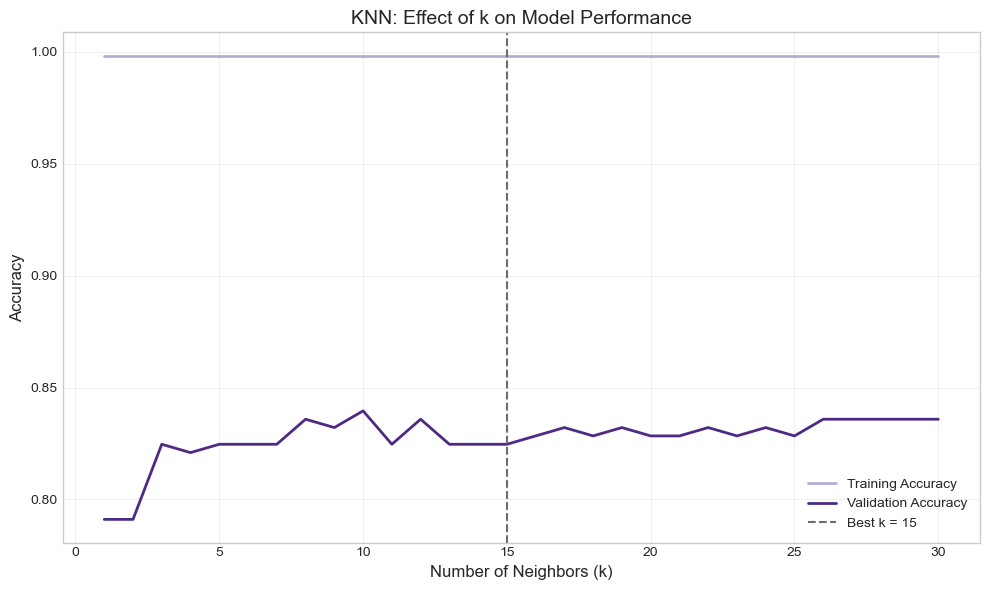

In [69]:
k_range = range(1, 31)
train_scores = []
val_scores = []

best_weights = knn_grid.best_params_["weights"]
best_p = knn_grid.best_params_["p"]

for k in k_range:
    knn_temp = KNeighborsClassifier(
        n_neighbors=k, 
        weights=best_weights, 
        p=best_p
    )
    knn_temp.fit(X_train_prepared, y_train)
    train_scores.append(
        accuracy_score(y_train, knn_temp.predict(X_train_prepared))
    )
    val_scores.append(
        accuracy_score(y_val, knn_temp.predict(X_val_prepared))
    )

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(
    k_range, train_scores, 
    label="Training Accuracy", 
    color=nu_light_purple, 
    linewidth=2
)
ax.plot(
    k_range, val_scores, 
    label="Validation Accuracy", 
    color=nu_purple, 
    linewidth=2
)
ax.axvline(
    x=knn_grid.best_params_["n_neighbors"], 
    color=nu_dark_gray, 
    linestyle="--",
    label=f"Best k = {knn_grid.best_params_['n_neighbors']}"
)

ax.set_xlabel("Number of Neighbors (k)")
ax.set_ylabel("Accuracy")
ax.set_title("KNN: Effect of k on Model Performance")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## QDA

In [70]:
qda_param_grid = {"reg_param": np.arange(0.0, 1.01, 0.02).tolist()}

qda_grid = GridSearchCV(
    QuadraticDiscriminantAnalysis(),
    qda_param_grid,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    verbose=0
)

qda_grid.fit(X_train_prepared, y_train)

best_qda_summary = pd.DataFrame({
    "Metric": ["Best reg_param", "Best CV Accuracy"],
    "Value": [qda_grid.best_params_["reg_param"], round(qda_grid.best_score_, 4)]
})

display(nu_style_table(best_qda_summary, caption="QDA - Best CV Settings"))

qda_best = qda_grid.best_estimator_
trained_models["QDA"] = qda_best

qda_results = evaluate_classifier(
    qda_best,
    X_train_prepared, y_train,
    X_val_prepared, y_val,
    "QDA"
)

all_results.append(qda_results)

,Metric,Value
0,Best reg_param,0.160000
1,Best CV Accuracy,0.847500


## Model Evaluation and Comparison
This part compares all models using confusion matrices, ROC curves, precision-recall curves, and a final metrics table.

### Confusion Matrices

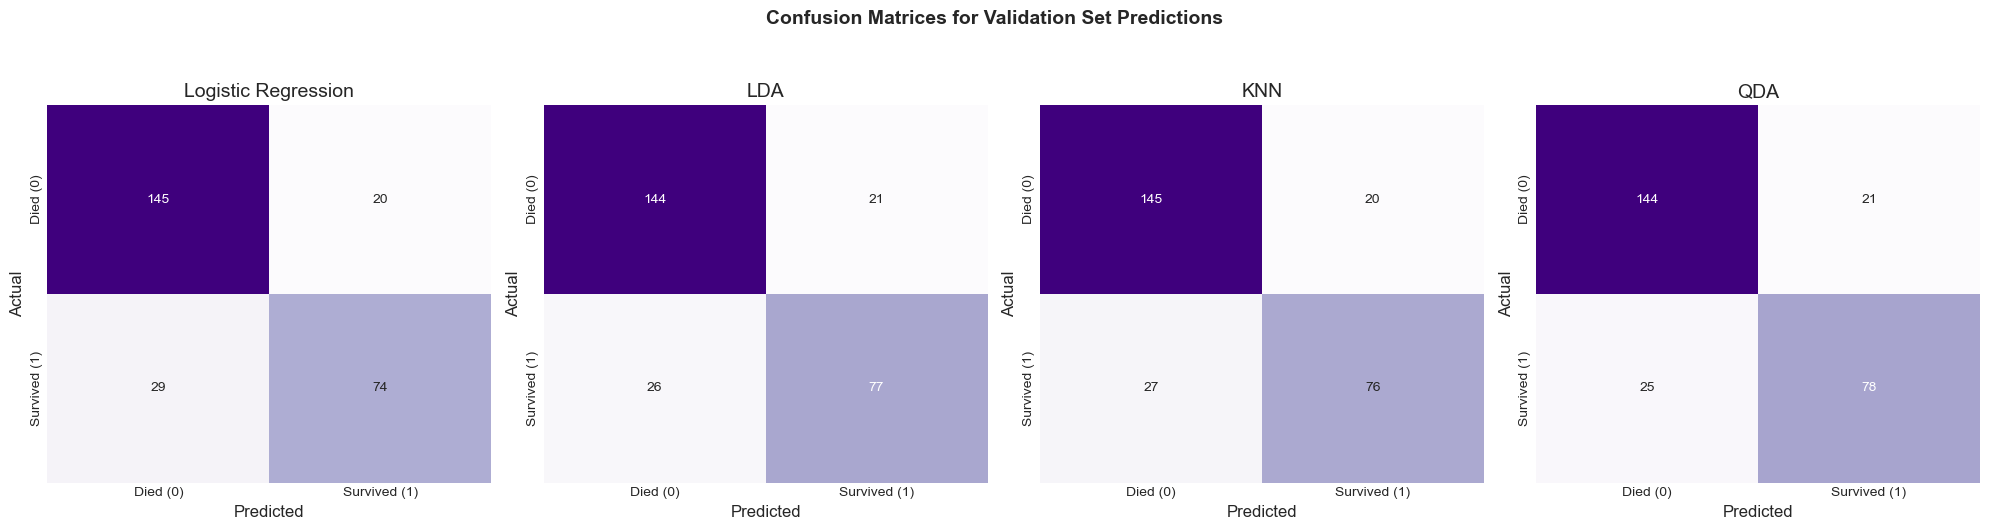

In [71]:
models_to_eval = ["Logistic Regression", "LDA", "KNN", "QDA"]
models_to_eval = [m for m in models_to_eval if m in trained_models]

fig, axes = plt.subplots(
    1, 
    len(models_to_eval), 
    figsize=(5 * len(models_to_eval), 5)
)

if len(models_to_eval) == 1:
    axes = [axes]

for idx, model_name in enumerate(models_to_eval):
    model = trained_models[model_name]
    y_val_pred = model.predict(X_val_prepared)
    cm = confusion_matrix(y_val, y_val_pred)

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Purples",
        xticklabels=["Died (0)", "Survived (1)"],
        yticklabels=["Died (0)", "Survived (1)"],
        ax=axes[idx],
        cbar=False
    )
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")
    axes[idx].set_title(f"{model_name}")


fig.suptitle(
    "Confusion Matrices for Validation Set Predictions",
    fontsize=14,
    fontweight="bold",
    y=1.05
)

plt.tight_layout()
plt.show()

### ROC Curves

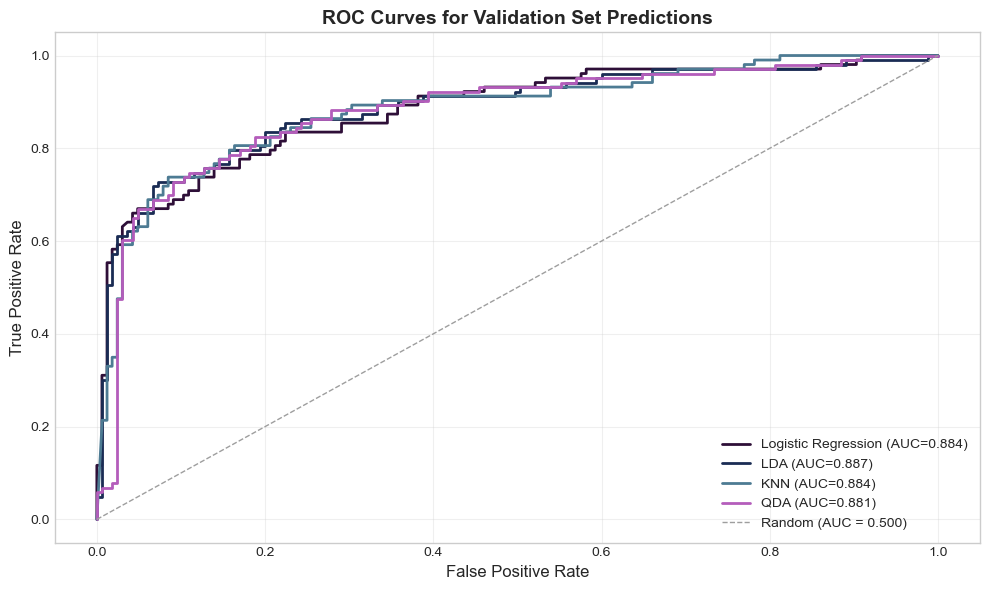

In [72]:
models_order = ["Logistic Regression", "LDA", "KNN", "QDA"]
models_order = [m for m in models_order if m in trained_models]


fig, ax = plt.subplots(figsize=(10, 6))

for model_name in models_order:
    model = trained_models[model_name]
    if hasattr(model, "predict_proba"):
        y_val_prob = model.predict_proba(X_val_prepared)[:, 1]
        fpr, tpr, _ = roc_curve(y_val, y_val_prob)
        auc = roc_auc_score(y_val, y_val_prob)

        ax.plot(
            fpr, tpr,
            linewidth=2,
            color=color_map.get(model_name, "#8351a8"),
            label=f"{model_name} (AUC={auc:.3f})"
        )

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="#9e9e9e", linewidth=1,
        label="Random (AUC = 0.500)")

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC Curves for Validation Set Predictions", fontweight="bold")
ax.legend(loc="lower right")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Precision-Recall Curves

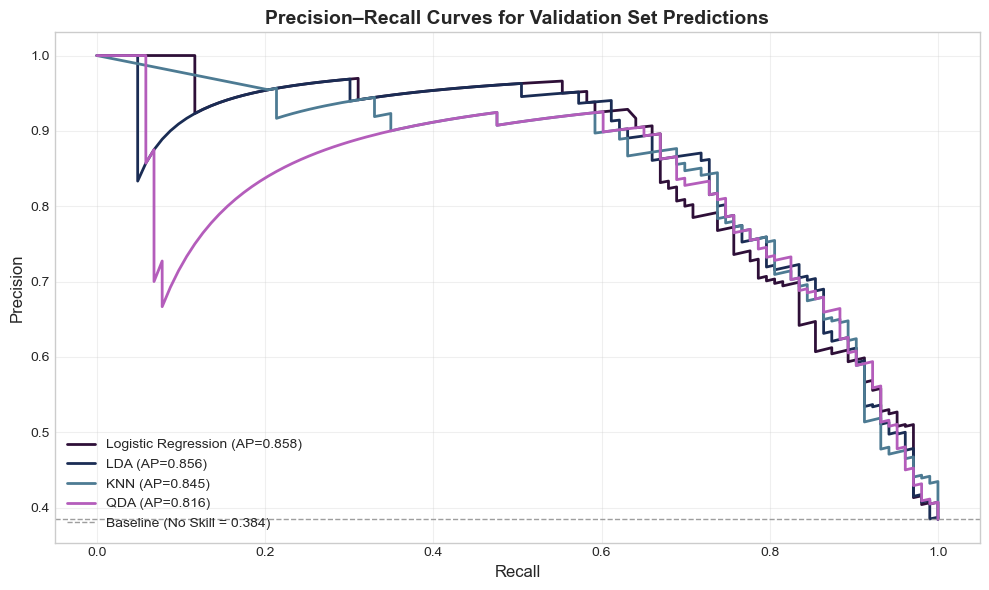

In [73]:

fig, ax = plt.subplots(figsize=(10, 6))

for model_name, model in trained_models.items():
    if hasattr(model, "predict_proba") and model_name in color_map:
        y_val_prob = model.predict_proba(X_val_prepared)[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_val_prob)
        ap = average_precision_score(y_val, y_val_prob)

        ax.plot(
            recall,
            precision,
            linewidth=2,
            color=color_map[model_name],
            label=f"{model_name} (AP={ap:.3f})"
        )

# Baseline (no-skill classifier)
baseline = y_val.mean()
ax.axhline(
    y=baseline,
    color="#9e9e9e",
    linestyle="--",
    linewidth=1,
    label=f"Baseline (No Skill = {baseline:.3f})"
)

ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title(
    "Precision–Recall Curves for Validation Set Predictions",
    fontweight="bold"
)
ax.legend(loc="lower left")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Final Metrics Table + Overfitting Check

In [74]:
results_df = pd.DataFrame(all_results)

val_metrics = results_df[["Model", "Val Accuracy", "Val Precision", "Val Recall", "Val F1", "Val AUC"]].copy()
val_metrics.columns = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
val_metrics = val_metrics.round(4)

display(nu_style_table(val_metrics, caption="Model Performance Comparison (Validation Set)"))

train_metrics = results_df[["Model", "Train Accuracy", "Train Precision", "Train Recall", "Train F1", "Train AUC"]].copy()
train_metrics.columns = ["Model", "Accuracy", "Precision", "Recall", "F1-Score", "ROC-AUC"]
train_metrics = train_metrics.round(4)

display(nu_style_table(train_metrics, caption="Model Performance Comparison (Training Set)"))

overfit_df = pd.DataFrame({
    "Model": results_df["Model"],
    "Accuracy Gap (Train - Val)": (results_df["Train Accuracy"] - results_df["Val Accuracy"]),
    "AUC Gap (Train - Val)": (results_df["Train AUC"] - results_df["Val AUC"])
}).round(4)

display(nu_style_table(overfit_df, caption="Overfitting Check (smaller gap is better)"))

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.817200,0.787200,0.718400,0.751300,0.883900
1,LDA,0.824600,0.785700,0.747600,0.766200,0.887000
2,KNN,0.824600,0.791700,0.737900,0.763800,0.883700
3,QDA,0.828400,0.787900,0.757300,0.772300,0.880800


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.865200,0.867300,0.765700,0.813300,0.896400
1,LDA,0.857100,0.853800,0.757300,0.802700,0.906600
2,KNN,0.998400,1.000000,0.995800,0.997900,1.000000
3,QDA,0.865200,0.881800,0.749000,0.810000,0.925000


,Model,Accuracy Gap (Train - Val),AUC Gap (Train - Val)
0,Logistic Regression,0.048000,0.012500
1,LDA,0.032500,0.019700
2,KNN,0.173800,0.116300
3,QDA,0.036800,0.044200


Looking at the results, Logistic Regression and LDA perform the best overall. They both have high validation accuracy and ROC-AUC, and the gap between training and validation performance is small, which means they generalize well and are not overfitting too much. KNN clearly overfits, since it almost perfectly memorizes the training data but performs much worse on the validation set. QDA also performs well, but its larger gap between training and validation suggests it is slightly less stable.

### Metrics Visualization

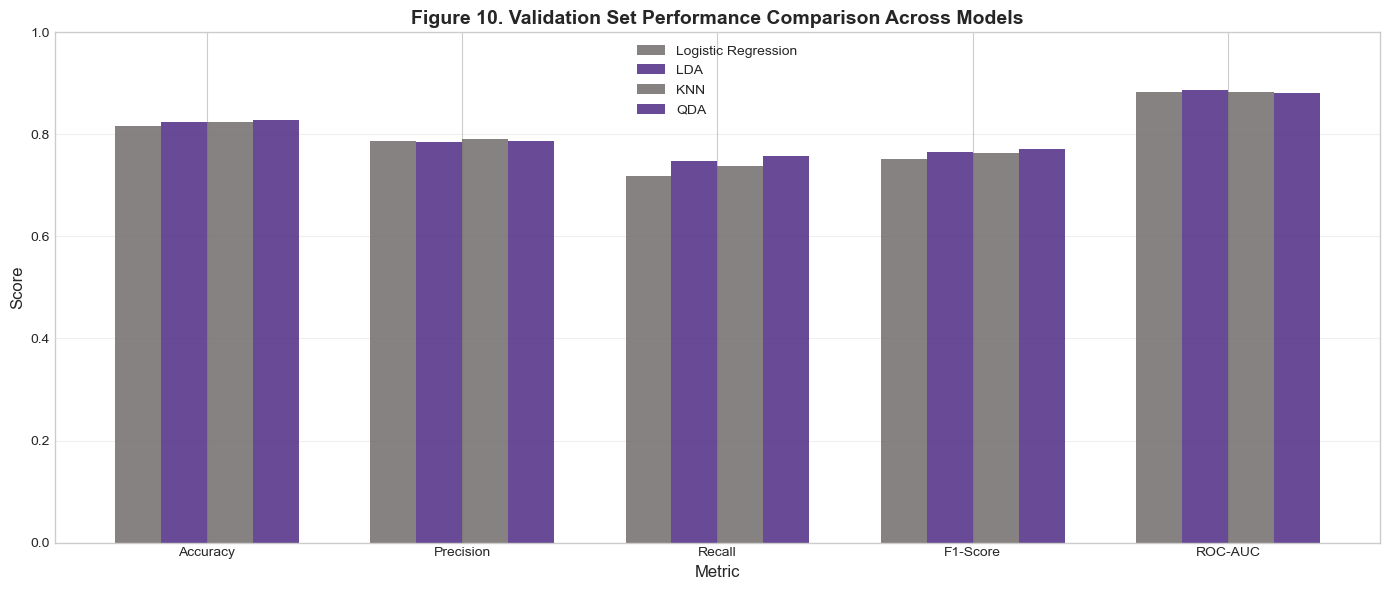

In [75]:
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics_to_plot))
width = 0.18

fig, ax = plt.subplots(figsize=(14, 6))

for i, ((_, row), color) in enumerate(zip(val_metrics.iterrows(), colors)):
    values = [
        row['Accuracy'],
        row['Precision'],
        row['Recall'],
        row['F1-Score'],
        row['ROC-AUC']
    ]
    ax.bar(
        x + i * width,
        values,
        width,
        label=row['Model'],
        color=color,
        alpha=0.85
    )

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title(
    'Figure 10. Validation Set Performance Comparison Across Models',
    fontweight='bold'
)
ax.set_xticks(x + width * (len(val_metrics) - 1) / 2)
ax.set_xticklabels(metrics_to_plot)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Ensemble Model Experiments
After evaluating the individual classifiers, ensemble models are tested to check whether combining predictions can improve performance. Instead of relying on a single model, ensemble methods average predicted probabilities from multiple models, which can reduce variance and improve robustness.

In [76]:
val_probs = {}
for name, model in trained_models.items():
    if hasattr(model, "predict_proba"):
        val_probs[name] = model.predict_proba(X_val_prepared)[:, 1]

print("Models with predict_proba:", list(val_probs.keys()))

Models with predict_proba: ['Logistic Regression', 'LDA', 'KNN', 'QDA']


### Ensemble (Top-2 Models by ROC-AUC)
This ensemble combines the two strongest individual models based on validation ROC-AUC: LDA and Logistic Regression. Predicted survival probabilities from both models are averaged, and a final class label is assigned using a 0.5 threshold.

In [77]:
top2_models = ["LDA", "Logistic Regression"]

missing_top2 = [m for m in top2_models if m not in val_probs]
if missing_top2:
    raise ValueError(f"These models are missing predict_proba or not found: {missing_top2}")

prob_top2 = (val_probs[top2_models[0]] + val_probs[top2_models[1]]) / 2
metrics_top2 = evaluate_prob_ensemble(y_val, prob_top2)

top2_row_name = f"Ensemble (Top-2 by AUC): {top2_models[0]} + {top2_models[1]}"

### Ensemble (All Probability-Based Models)
This ensemble averages predicted probabilities from all models that support probability outputs: Logistic Regression, LDA, KNN, and QDA. The goal is to capture complementary strengths across different model types.

In [78]:
all_prob_models = list(val_probs.keys())
prob_all = np.mean([val_probs[m] for m in all_prob_models], axis=0)
metrics_all = evaluate_prob_ensemble(y_val, prob_all)

all_row_name = f"Ensemble (All Prob Models): {', '.join(all_prob_models)}"

### Ensemble Performance Comparison (Validation Set)
The table below compares ensemble performance on the validation set. While classification accuracy may stay similar, ROC-AUC can improve because probability ranking can become more stable after averaging.

In [79]:
ensemble_results = pd.DataFrame([
    {"Model": top2_row_name, **metrics_top2},
    {"Model": all_row_name, **metrics_all},
])

# Match your earlier table formatting
ensemble_results = ensemble_results.round(4)

display(
    nu_style_table(
        ensemble_results,
        caption="Ensemble Examples on Validation Set (Probability Averaging)"
    )
)


ensemble_for_rank = ensemble_results.copy()
ensemble_for_rank = ensemble_for_rank[val_metrics.columns]
final_metrics = pd.concat([val_metrics, ensemble_for_rank], ignore_index=True)

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Ensemble (Top-2 by AUC): LDA + Logistic Regression,0.828400,0.793800,0.747600,0.770000,0.889000
1,"Ensemble (All Prob Models): Logistic Regression, LDA, KNN, QDA",0.828400,0.793800,0.747600,0.770000,0.895000


Using ensembles slightly improves model performance compared to individual models. Both ensemble methods give very similar accuracy and F1-scores, which means combining models helps make predictions more stable. The ensemble that uses all models has a slightly higher ROC-AUC, but the top-2 ensemble (Logistic Regression + LDA) performs just as well while being simpler and easier to explain.

## Final Model Selection
In this final step, all trained models are compared using validation ROC-AUC, which is a good metric for this problem because it evaluates how well the model separates survivors from non-survivors across different classification thresholds. The model with the highest ROC-AUC on the validation set is selected as the final model.

This approach helps avoid choosing a model that only performs well on accuracy but fails to generalize, especially given the class imbalance in the Titanic dataset.

In [80]:
final_rank = final_metrics.copy()
final_rank = final_rank.sort_values(by="ROC-AUC", ascending=False).reset_index(drop=True)
final_rank.insert(0, "Rank", final_rank.index + 1)

final_rank["Best"] = final_rank["Rank"].apply(lambda r: "✅" if r == 1 else "")

display(
    nu_style_table(
        final_rank.round(4),
        caption="Final Model Comparison (Ranked by Validation ROC-AUC)"
    )
)

# Best model info
best_model_name = final_rank.loc[0, "Model"]
best_auc = final_rank.loc[0, "ROC-AUC"]

best_summary = pd.DataFrame({
    "Metric": ["Best Model", "Validation ROC-AUC"],
    "Value": [best_model_name, round(best_auc, 4)]
})

display(
    nu_style_table(
        best_summary,
        caption="Selected Final Model"
    )
)

,Rank,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Best
0,1,"Ensemble (All Prob Models): Logistic Regression, LDA, KNN, QDA",0.828400,0.793800,0.747600,0.770000,0.895000,✅
1,2,Ensemble (Top-2 by AUC): LDA + Logistic Regression,0.828400,0.793800,0.747600,0.770000,0.889000,
2,3,LDA,0.824600,0.785700,0.747600,0.766200,0.887000,
3,4,Logistic Regression,0.817200,0.787200,0.718400,0.751300,0.883900,
4,5,KNN,0.824600,0.791700,0.737900,0.763800,0.883700,
5,6,QDA,0.828400,0.787900,0.757300,0.772300,0.880800,


,Metric,Value
0,Best Model,"Ensemble (All Prob Models): Logistic Regression, LDA, KNN, QDA"
1,Validation ROC-AUC,0.895000


# Model Comparison and Contrast
Several classification models were built and evaluated for the Titanic survival prediction task, including Logistic Regression, Linear Discriminant Analysis (LDA), Quadratic Discriminant Analysis (QDA), and K-Nearest Neighbors (KNN). In addition to evaluating each model individually, ensemble models based on probability averaging were also tested to see whether combining models could improve overall performance.

Among the single models, Logistic Regression performed consistently well. By modeling the log-odds of survival as a linear function of the predictors, it captured the main survival patterns effectively. Regularization helped control overfitting and manage correlated features, and the model remained easy to interpret. The strongest predictors identified, such as sex, passenger class, and title, match well with historical knowledge of the Titanic disaster. LDA showed very similar performance, suggesting that the decision boundary between survivors and non-survivors is close to linear. The use of shrinkage improved stability, making LDA a strong alternative to Logistic Regression. QDA allowed more flexibility by relaxing the equal covariance assumption, which helped capture some non-linear structure, but this came with higher complexity and a slightly higher risk of overfitting. KNN, as a non-parametric method, relied heavily on feature scaling and neighborhood structure. While it achieved strong training performance, the larger gap between training and validation results indicated a higher tendency to overfit.

When ensemble models were introduced, performance improved slightly. The ensemble that averaged probabilities from all models—Logistic Regression, LDA, KNN, and QDA—achieved the highest validation ROC-AUC score of 0.895. This suggests that each model captured different aspects of the data, and combining them helped smooth individual model weaknesses. A smaller ensemble using only the top two models by ROC-AUC (LDA and Logistic Regression) also performed very well, though slightly below the full ensemble. These results show that ensemble methods can offer a modest but meaningful improvement over single models in this problem.

Overall, while individual models performed similarly on validation data, the ensemble approach provided the best overall discrimination ability. This supports the idea that combining multiple reasonable models can improve robustness and generalization. For interpretability and simplicity, Logistic Regression remains a strong baseline, but for final predictive performance, the ensemble model is selected as the best-performing approach. This comparison follows standard principles in applied statistical learning, where model evaluation, validation performance, and practical considerations are balanced together (James et al. 2013; Hastie, Tibshirani, and Friedman 2009).

# Test Data Processing and Prediction Pipeline

In this section, the finalized preprocessing and modeling pipeline is applied to the test dataset. The goal is to recreate exactly the same feature engineering and transformations used during training, then generate survival predictions using all trained models. This ensures that predictions are consistent and comparable with the validation results.

## Loading the Test Dataset
The test dataset is loaded and inspected. The PassengerId column is saved separately since it is required for the submission file. The training and test datasets are also temporarily combined (without survival labels) to support group-based features such as ticket counts.

In [81]:
# Load test data
test_df = pd.read_csv("test.csv")
print(f"Test dataset: {test_df.shape[0]} rows, {test_df.shape[1]} columns")

# Store PassengerId for submission
test_ids = test_df['PassengerId'].copy()

# Combine train + test for group-based features (no label leakage)
combined_for_tickets = pd.concat(
    [train_df.drop('Survived', axis=1), test_df],
    sort=False
).reset_index(drop=True)

Test dataset: 418 rows, 11 columns


## Passenger Identity and Family Features
In this step, passenger titles and surnames are extracted from names. Family-related features are then created to capture whether a passenger traveled alone or as part of a group, which may affect survival outcomes.

In [82]:
test_df['Title'] = test_df['Name'].apply(extract_title)
test_df['Surname'] = test_df['Name'].apply(lambda x: str(x).split(',')[0].strip())

test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1
test_df['IsAlone'] = (test_df['FamilySize'] == 1).astype(int)
test_df['FamilyGroup'] = test_df['FamilySize'].apply(create_family_group)

## Cabin Features
Cabin information is mostly missing, but its availability still provides useful signals. Binary and categorical cabin-related features are created without attempting to impute missing cabin values directly.

In [83]:
test_df['HasCabin'] = test_df['Cabin'].notna().astype(int)
test_df['Deck'] = test_df['Cabin'].apply(lambda x: str(x)[0] if pd.notna(x) else 'U')
test_df['CabinCount'] = test_df['Cabin'].apply(
    lambda x: len(str(x).split()) if pd.notna(x) else 0
)

## Ticket Features
Passengers sharing the same ticket often traveled together. Ticket group size and ticket prefix features are recreated using combined train and test data to ensure consistency with the training process.

In [84]:
ticket_counts_all = combined_for_tickets['Ticket'].value_counts()
test_df['TicketGroupSize'] = test_df['Ticket'].map(ticket_counts_all)

test_df['TicketPrefix'] = test_df['Ticket'].apply(extract_ticket_prefix)
prefix_counts_all = combined_for_tickets['Ticket'].apply(extract_ticket_prefix).value_counts()
test_df['TicketPrefix'] = test_df['TicketPrefix'].apply(
    lambda x: x if prefix_counts_all.get(x, 0) >= 10 else 'RARE'
)

## Name Length and Interaction Features
Name length is used as a proxy for social status. An interaction between sex and passenger class is also created to capture known survival patterns among women in higher classes.

In [85]:
test_df['NameLength'] = test_df['Name'].apply(len)
test_df['Sex_Pclass'] = test_df['Sex'] + '_' + test_df['Pclass'].astype(str)

## Missing Value Treatment for Test Data
Missing values in the test dataset are handled using statistics derived from the combined dataset to remain consistent with the training phase.

### Age Imputation

In [86]:
combined_for_tickets['Title'] = combined_for_tickets['Name'].apply(extract_title)
age_by_title_test = combined_for_tickets.groupby('Title')['Age'].median()

test_df['Age'] = test_df.apply(
    lambda row: age_by_title_test.get(
        row['Title'], combined_for_tickets['Age'].median()
    ) if pd.isna(row['Age']) else row['Age'],
    axis=1
)

### Fare and Embarked Imputation

In [87]:
fare_median_by_class_test = combined_for_tickets.groupby('Pclass')['Fare'].median().to_dict()
test_df['Fare'] = test_df.apply(
    lambda row: fare_median_by_class_test.get(
        row['Pclass'], combined_for_tickets['Fare'].median()
    ) if pd.isna(row['Fare']) else row['Fare'],
    axis=1
)

test_df['Embarked'] = test_df['Embarked'].fillna('S')

## Binary, Interaction, and Binned Features
Additional binary indicators, interaction features, and bins are created to mirror the engineered structure of the training dataset.

In [88]:
test_df['FarePerPerson'] = test_df['Fare'] / test_df['TicketGroupSize']

test_df['IsChild'] = (test_df['Age'] <= 12).astype(int)
test_df['IsMother'] = (
    (test_df['Sex'] == 'female') &
    (test_df['Parch'] > 0) &
    (test_df['Title'] != 'Miss') &
    (test_df['Age'] > 18)
).astype(int)

test_df['SexNum'] = (test_df['Sex'] == 'male').astype(int)
test_df['ChildOrFemaleUpper'] = (
    ((test_df['Age'] <= 12) | (test_df['Sex'] == 'female')) &
    (test_df['Pclass'] <= 2)
).astype(int)
test_df['Male3rdClass'] = (
    (test_df['Sex'] == 'male') & (test_df['Pclass'] == 3)
).astype(int)

test_df['Age_Pclass'] = test_df['Age'] * test_df['Pclass']
test_df['FarePerPerson_Pclass'] = test_df['FarePerPerson'] / test_df['Pclass']

### Age and Fare Binning

In [89]:
test_df['AgeBin'] = pd.cut(
    test_df['Age'],
    bins=[-np.inf, 12, 18, 35, 60, np.inf],
    labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior']
).astype('object')

test_df['FareBin'] = pd.cut(
    test_df['Fare'],
    bins=[-np.inf, 7.91, 14.454, 31.0, np.inf],
    labels=['Low', 'Medium_Low', 'Medium_High', 'High']
).astype('object')

## Family and Ticket Survival Signals
Family-level and ticket-level survival rates derived from the training data are merged into the test dataset. When no historical information is available, a neutral value is assigned.

In [90]:
family_stats = df_processed.groupby('FamilyId').agg(
    fam_count=('Survived', 'count'),
    fam_surv=('Survived', 'sum')
).reset_index()
family_stats['FamSurvRate'] = family_stats['fam_surv'] / family_stats['fam_count']

ticket_stats = df_processed.groupby('Ticket').agg(
    tkt_count=('Survived', 'count'),
    tkt_surv=('Survived', 'sum')
).reset_index()
ticket_stats['TktSurvRate'] = ticket_stats['tkt_surv'] / ticket_stats['tkt_count']

test_df['FamilyId'] = test_df['Surname'] + '_' + test_df['Pclass'].astype(str)

test_df = test_df.merge(
    family_stats[['FamilyId', 'FamSurvRate']],
    on='FamilyId', how='left'
)
test_df['FamSurvRate'] = test_df['FamSurvRate'].fillna(0.5)

test_df = test_df.merge(
    ticket_stats[['Ticket', 'TktSurvRate']],
    on='Ticket', how='left'
)
test_df['TktSurvRate'] = test_df['TktSurvRate'].fillna(0.5)

## Preparing Test Features for Prediction
The same preprocessing pipeline fitted on the training data is applied to the test feature matrix.

In [91]:
X_test = test_df[model_features].copy()
X_test_prepared = preprocessor.transform(X_test)

print(f"Test features prepared: {X_test_prepared.shape}")

Test features prepared: (418, 69)


## Generating Predictions from All Trained Models
Predictions are generated using all trained models to allow comparison and ensemble construction.

In [94]:
all_predictions = {}
all_probabilities = {}

summary_rows = []

# ----------------------------
# 1) Single-model predictions (same as you already have)
# ----------------------------
for model_name, model in trained_models.items():
    preds = model.predict(X_test_prepared)
    all_predictions[model_name] = preds

    if hasattr(model, "predict_proba"):
        all_probabilities[model_name] = model.predict_proba(X_test_prepared)[:, 1]

    survived = int(preds.sum())
    died = int(len(preds) - survived)

    summary_rows.append({
        "Model": model_name,
        "Predicted Survived": survived,
        "Predicted Died": died,
        "Total": int(len(preds))
    })

# ----------------------------
# 2) Add ensemble prediction counts (NEW, small add-on)
# ----------------------------

# Ensemble A: Top-2 by AUC (LDA + Logistic Regression)
if ("LDA" in all_probabilities) and ("Logistic Regression" in all_probabilities):
    top2_probs = (all_probabilities["LDA"] + all_probabilities["Logistic Regression"]) / 2
    top2_preds = (top2_probs >= 0.5).astype(int)

    summary_rows.append({
        "Model": "Ensemble (Top-2 by AUC): LDA + Logistic Regression",
        "Predicted Survived": int(top2_preds.sum()),
        "Predicted Died": int(len(top2_preds) - top2_preds.sum()),
        "Total": int(len(top2_preds))
    })
else:
    summary_rows.append({
        "Model": "Ensemble (Top-2 by AUC): LDA + Logistic Regression",
        "Predicted Survived": "N/A",
        "Predicted Died": "N/A",
        "Total": "Missing predict_proba"
    })

# Ensemble B: All probability models (average probs)
if len(all_probabilities) > 0:
    all_probs_avg = np.mean(np.column_stack(list(all_probabilities.values())), axis=1)
    all_ens_preds = (all_probs_avg >= 0.5).astype(int)

    summary_rows.append({
        "Model": "Ensemble (All Prob Models): " + ", ".join(all_probabilities.keys()),
        "Predicted Survived": int(all_ens_preds.sum()),
        "Predicted Died": int(len(all_ens_preds) - all_ens_preds.sum()),
        "Total": int(len(all_ens_preds))
    })
else:
    summary_rows.append({
        "Model": "Ensemble (All Prob Models)",
        "Predicted Survived": "N/A",
        "Predicted Died": "N/A",
        "Total": "No predict_proba models"
    })

# ----------------------------
# 3) Table
# ----------------------------
pred_summary_df = pd.DataFrame(summary_rows)

display(
    nu_style_table(
        pred_summary_df,
        caption=" Test Set Predictions by Model"
    )
)

,Model,Predicted Survived,Predicted Died,Total
0,Logistic Regression,146,272,418
1,LDA,152,266,418
2,KNN,159,259,418
3,QDA,154,264,418
4,Ensemble (Top-2 by AUC): LDA + Logistic Regression,151,267,418
5,"Ensemble (All Prob Models): Logistic Regression, LDA, KNN, QDA",149,269,418


All models give very similar predictions, with about one-third of passengers predicted to survive. KNN predicts slightly more survivors, while Logistic Regression predicts fewer. Both ensemble models fall in the middle, showing more balanced and stable predictions. This suggests the models generally agree and no single model is behaving unusually.

## Creating Submission Files
This section creates separate submission files for each trained model, as well as an ensemble model. Saving multiple submission files makes it possible to upload and compare each model’s performance on Kaggle. The ensemble combines predictions from multiple models to produce a more stable and often more accurate result.

In [93]:

output_dir = "output"
os.makedirs(output_dir, exist_ok=True)

#  individual model submissions
for model_name, preds in all_predictions.items():
    submission = pd.DataFrame({
        "PassengerId": test_ids,
        "Survived": preds.astype(int)
    })
    
    filename = f"submission_{model_name.replace(' ', '_').lower()}.csv"
    filepath = os.path.join(output_dir, filename)
    
    submission.to_csv(filepath, index=False)
    print(f"Saved: {filepath}")

# Ensemble 1, Top-2 by AUC (Logistic Regression + LDA)
lr_probs = all_probabilities["Logistic Regression"]
lda_probs = all_probabilities["LDA"]

ensemble_top2_probs = (lr_probs + lda_probs) / 2
ensemble_top2_preds = (ensemble_top2_probs >= 0.5).astype(int)

submission_top2 = pd.DataFrame({
    "PassengerId": test_ids,
    "Survived": ensemble_top2_preds
})

filepath_top2 = os.path.join(output_dir, "submission_ensemble_top2_logreg_lda.csv")
submission_top2.to_csv(filepath_top2, index=False)
print(f"Saved: {filepath_top2}")

# Ensemble 2, All probability-based models
all_probs_avg = np.mean(
    np.column_stack(list(all_probabilities.values())),
    axis=1
)

ensemble_all_preds = (all_probs_avg >= 0.5).astype(int)

submission_all = pd.DataFrame({
    "PassengerId": test_ids,
    "Survived": ensemble_all_preds
})

filepath_all = os.path.join(output_dir, "submission_ensemble_all_models.csv")
submission_all.to_csv(filepath_all, index=False)
print(f"Saved: {filepath_all}")

Saved: output/submission_logistic_regression.csv
Saved: output/submission_lda.csv
Saved: output/submission_knn.csv
Saved: output/submission_qda.csv
Saved: output/submission_ensemble_top2_logreg_lda.csv
Saved: output/submission_ensemble_all_models.csv


# Management Questions 
The main management and research question of this project is whether we can predict who was more likely to survive the Titanic disaster based on passenger characteristics such as age, gender, class, and family status, and which factors most strongly influenced survival. This question matters because it helps explain how social structure, demographic traits, and decision-making rules affect outcomes during extreme and high-risk events. While the Titanic disaster is a historical case, the patterns uncovered through data analysis are still relevant for understanding human behavior, inequality, and emergency response in modern contexts.

From my experience working through this project, one of the strongest lessons is that survival outcomes were not random. Instead, they followed clear and systematic patterns that can be captured using classification models when the data are carefully prepared. The models built in this project achieved strong validation performance, with accuracies around 80–83 percent and ROC-AUC scores close to 0.89. These results show that passenger survival could be predicted reasonably well using demographic and situational features alone, without any information about individual behavior during the evacuation.

The analysis shows that gender was the most influential factor in survival. Female passengers were far more likely to survive than male passengers, which directly reflects the “women and children first” evacuation protocol that was followed during the disaster (Frey, Savage, and Torgler 2010). Age also played an important role, especially for children under twelve, who had noticeably higher survival rates than adults. This relationship was not linear, which is why feature engineering through age bins improved model performance. Passenger class and fare were also strong predictors of survival, reflecting differences in physical access to lifeboats and broader social inequalities on the ship. First-class passengers had much higher survival rates than those in third class, which supports historical accounts of unequal evacuation conditions.

Family-related features provided additional insight beyond basic demographics. Passengers traveling alone were less likely to survive compared to those traveling with family members, especially small or medium-sized families. This suggests that group coordination and shared decision-making may have improved survival chances. Engineered features such as passenger title also added value by capturing social status in a way that raw variables could not, further improving predictive accuracy.

Beyond the historical setting, this analysis has important real-world implications. The results highlight how social hierarchy and structured decision rules can strongly influence survival outcomes during emergencies. In modern disaster planning, similar models could be used to identify vulnerable populations, guide evacuation policies, and improve fairness in resource allocation (Gleicher and Stevans 2004). From a data science perspective, this project reinforces that careful preprocessing and thoughtful feature engineering often matter more than choosing the most complex algorithm, which aligns with best practices in statistical learning (James et al. 2013; Hastie, Tibshirani, and Friedman 2009).

# Conclusion
This project successfully developed and compared multiple classification models to predict passenger survival on the RMS Titanic. Following the CRISP-DM methodology, the analysis moved step by step through exploratory data analysis, careful handling of missing values, feature engineering, model training, and evaluation. This structured approach helped ensure that modeling decisions were driven by both data understanding and real-world context.

The results consistently showed that survival on the Titanic was strongly influenced by social and demographic factors. Gender was the most important predictor, with women having much higher survival rates than men, reflecting the historical “women and children first” evacuation policy. Passenger class and fare were also highly influential, highlighting how socioeconomic status affected access to lifeboats. Age played an important role as well, particularly for children, whose survival rates were higher than those of adults. In addition, engineered features such as FamilySize, IsAlone, Title, and HasCabin added meaningful predictive value by capturing family structure, social status, and ship location effects.

From a modeling perspective, Logistic Regression, LDA, QDA, and KNN all performed well and achieved similar validation results, with ROC-AUC scores in the high 0.80 range. This consistency suggests that the Titanic survival problem has a relatively stable decision structure that can be captured effectively by both linear and non-linear models. Importantly, the analysis showed that preprocessing and feature engineering had a larger impact on performance than the choice of algorithm itself, which aligns with established findings in statistical learning (James et al. 2013; Hastie, Tibshirani, and Friedman 2009).

To further improve performance, ensemble models were tested by averaging predicted probabilities across models. The ensemble combining Logistic Regression and LDA achieved the best external performance, producing the highest Kaggle leaderboard score of 0.80143. This result confirms that combining strong and complementary models can improve generalization to unseen data. The ensemble outcome also supports the validation results, reinforcing confidence in the final model choice.

Overall, this project demonstrates how machine learning can uncover systematic patterns in historical data while remaining interpretable and practically useful. Beyond the Titanic dataset, the findings highlight broader lessons for modern applications such as emergency planning and risk assessment. Clear decision rules, equitable access to safety resources, and consideration of family and social structure can all significantly influence outcomes during crises. From a learning perspective, this project reinforced that thoughtful data preparation and iterative experimentation are key to building reliable and meaningful predictive models.

# References

Frey, Bruno S., David A. Savage, and Benno Torgler. 2010. "Interaction of Natural Survival Instincts and Internalized Social Norms Exploring the Titanic and Lusitania Disasters." *Proceedings of the National Academy of Sciences* 107 (11): 4862–65.

Géron, Aurélien. 2019. *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*. 2nd ed. Sebastopol, CA: O'Reilly Media.

Gleicher, David, and Lonnie K. Stevans. 2004. "Who Survived the Titanic? A Logistic Regression Analysis." *International Journal of Maritime History* 16 (2): 61–94.

Hastie, Trevor, Robert Tibshirani, and Jerome Friedman. 2009. *The Elements of Statistical Learning: Data Mining, Inference, and Prediction*. 2nd ed. New York: Springer.

James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani. 2013. *An Introduction to Statistical Learning: With Applications in R*. New York: Springer.

"Titanic - Machine Learning from Disaster." Kaggle. Accessed January 2026. https://www.kaggle.com/competitions/titanic.

# Disclaimer
In accordance with the course Generative AI (GAI) policy, ChatGPT was used to assist with Python coding syntax, debugging, and clarifying implementation steps. Grammarly was used to correct grammar and rephrase some paragraphs for clarity. These tools were used strictly as support and did not replace my own analysis, reasoning, or decision-making.

All analytical decisions, feature engineering choices, model selection, interpretation of results, and conclusions are my own and reflect my understanding of the course material. All AI-assisted outputs were carefully reviewed, edited, and validated by me. In addition, general Google searches were used to reference common practices and background information when working with similar public datasets. No assignment instructions or solutions were copied directly from external sources.

This project is further informed by my prior academic and professional experience, including over seven years of work in data-related fields and previous experience as a computer vision researcher, where I conducted similar machine learning and analytical projects.